# Hot Air Balloon Dynamic Control
Prepared by: Stephen Cini (scini@nd.edu, [@sscini](https://github.com/sscini), 2024) and Oliver Harris (oharris2@nd.edu, [@OliverHarris47](https://github.com/OliverHarris47), 2024)

In [1]:
# Install Pyomo and solvers for Google Colab
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    !pip install okabeito --quiet
    import helper
    helper.easy_install()

else:
# Make sure helper.py is installed locally in same location as notebook
    sys.path.insert(0, '../')
    %pip install okabeito --quiet
    import helper

helper.set_plotting_style()

import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyomo.dae as dae
import idaes
import okabeito

Note: you may need to restart the kernel to use updated packages.


## Learning Objectives

*   Review syntax and components in Pyomo.DAE
*   See how change in objective function can affect model behavior
*   Highlight importance of realistic initialization conditions and parameter values



## Introduction

In this notebook, we adapt the example in [](../notebooks/3/PyomoDAE_TCLab.ipynb) to discuss the model formulation for controlling height in a hot air balloon during a planned hot air balloon ride.

[](https://raw.githubusercontent.com/ndcbe/optimization/main/media/contrib/balloon.jpg)

Picture adapted from https://www.real-world-physics-problems.com/hot-air-balloon-physics.html.


Instead of controlling the temperature of the heater and sensor utilizing a heater, we control the height of the hot air balloon by utilizing the lift force generated by the balloon being heated.



### Hot Air Balloons

A hot air balloon operates based on the principle of buoyancy, where hot air inside the balloon is less dense than the cooler air outside, causing the balloon to rise. The principle forces for hot air balloon operation are: lift, weight, and drag. The objective of our project, is to design a Pyomo model that controls a hot air balloon to follow the average path taken by a balloon during a tourism trip. A free body diagram describing how the principle forces act can be seen below.

[](https://raw.githubusercontent.com/ndcbe/optimization/main/media/contrib/ballon_freebody.png)

Picture adapted from https://charm.stanford.edu/ENGR1052016/AnthonyBombikJayantMukhopadhaya.




## Model Formulation: No Set Objective



\begin{align*}
\max ~~ & 0 \\
\mathrm{s.t.}~~ & \frac{dh}{dt} = v(t) \\
 & D(t) = b \cdot v(t)^2 \\
 & \frac{dv}{dt} \cdot m = L(t) - m \cdot g - D(t)  \\
 & h(t_0) = 0 \\
 & v(t_0) = 0 \\
 & L(t) = L_{ramp} = 10000, \quad \forall t \in [t_0, t_f]
\end{align*}

The equation of motion for the hot air balloon is then:
\begin{align*}
& m \cdot \ddot{y} = L - m \cdot g - D \\
& D = b \dot{y}^2
\end{align*}

Where:
\begin{align*}
m & \text{ : Mass (kg)} \\
\ddot{y} & \text{ : Acceleration (m/s}^2\text{)}\\
\dot{y} & \text{ : Velocity (m/s)}\\
L & \text{ : Lift Force (N or kg m/s}^2\text{)} \\
g & \text{ : Gravitational Constant (m/s}^2\text{)} \\
D & \text{ : Drag Force (N)} \\
b & \text{ : Drag Constant (kg/m)}
\end{align*}


###  Degree of Freedom Analysis

**Versions 0 --> 1**

In our model formulations for versions 0 and 1, we are simulating the balloon dynamics using a step-input (Lift). For plotting purposes, lift was defined as a variable with respect to time. However, a constraint was added that fixed the lift force to 10,000 Newtons. This effectively treats lift as a parameter and not a variable.

Variables: h(t) , v(t) , D(t) \
Number of Constraints: 3

$DOF = Variables - Constraints = 3 - 3 = 0$

For versions 0 and 1 of our model, the models have 0 DOF. This matches the `'ipopt'` solver output:

Total Number of Variables: 364

Total Number of Equality Constraints: 364


### Define Model Constants

Here, we define the characteristics of the balloon we will be simulating in this notebook.


In [2]:
# Define Fixed Parameters from model inspiration sources
rho_air = 1.225       # kg/m^3
g = 9.81              # m/s^2
radius = 10          # m
m_balloon = 750       # kg
cD = 0.47

S = 4*np.pi*radius**2    # wetted surface area m^2
b = 1/2*rho_air*cD*S # kg/m

# Print calculated values
print(f'S = {np.round(S, 2)} m^2')
print(f'b = {np.round(b, 2)} kg/m')

S = 1256.64 m^2
b = 361.75 kg/m


### Function Definition

Here, we set up the Discretization/Initialization, Solve, and Plotting/Visualization Functions for use in each of our models for different scenarios with the hot air balloon. Similar to the TCLab, we use `dae.collocation` for discretizing the model, and use the continous solver `'ipopt'`.



In [3]:
# Set-Up the Discretization/Initialization Function for the Model
def discretize_initialize(m, nfe):
    ''' Discretize and initialize model.

    Inputs:
        m: Model to discretize.
        nfe: Number of finite elements

    Returns:
        m: Discretized model.

    '''

    # Transform the Model using the 'dae.collocation' strategy.
    discretizer = pyo.TransformationFactory('dae.collocation')
    discretizer.apply_to(m, nfe=nfe, wrt=m.t) # default ncp = 3

    # Specify Initial Conditions
    m.h[0].fix(0)
    m.v[0].fix(0)

    return m

# Set-Up Solve Function
def solve_model(m, tee = True):

    ''' Solves model with ipopt.

    Inputs:
        m: Model to solve.
        tee: Whether to print full output

    Returns:
        m: Solved model.

    '''

    # Specify Solver
    solver = pyo.SolverFactory('ipopt')
    # Solve the Model
    solver.solve(m, tee=tee)

    return m

# Set up list for colors using okabeito color scheme
okabeito_list = [okabeito.lightblue, okabeito.yellow, okabeito.orange,
                 okabeito.green, okabeito.purple, okabeito.red, okabeito.blue,
                 okabeito.black] #list of colors from the okabeito color pallete

# Set-Up the Plotting/Visualization Function
def visualize_model(m):
    ''' Plotting model function with publication quality for main plots
    used in notebook.

    Inputs:
        m: Model to plot

    Returns:
        fig, ax: Plot information from model. Allows for further additions.'''
    # Collect the data
    t = [i for i in m.t]
    h = [pyo.value(m.h[i]) for i in m.t]
    v = [pyo.value(m.v[i]) for i in m.t]
    D = [pyo.value(m.D[i]) for i in m.t]
    L = [pyo.value(m.L[i])/1000 for i in m.t] #plotting in kN

    # Plot with subplots
    fig, axs = plt.subplots(3, 1, dpi = 200, figsize=(8, 12.8))

    colors = okabeito_list
    # Plot Height vs Time
    axs[0].plot(t, h, label = 'height_model', linewidth = 3, color = colors[0])
    axs[0].set_ylabel('Height (m)', fontweight = 'bold', fontsize = 16)

    # Plot Velocity vs Time
    axs[1].plot(t, v, linewidth = 3, color = colors[0])
    axs[1].set_ylabel('Velocity (m/s)', fontweight = 'bold', fontsize = 16)

    # Lift (m/s^2) vs time
    axs[2].plot(t, L, linewidth = 3, color = colors[0])
    axs[2].set_xlabel('Time (s)', fontweight = 'bold', fontsize = 16)
    axs[2].set_ylabel('Lift (kN)', fontweight = 'bold', fontsize = 16)

    # Adjust layout to prevent overlap and add spacing
    axs[0].tick_params(direction = 'in', labelsize=15)
    axs[1].tick_params(direction = 'in', labelsize=15)
    axs[2].tick_params(direction = 'in', labelsize=15)
    fig.tight_layout()
    return fig, axs



### Version 0: Simulate the Balloon Dynamics

We modeled our hot air balloon with an adapted model from CHARM Lab at Stanford University (https://charm.stanford.edu/ENGR1052016/AnthonyBombikJayantMukhopadhaya). Their analysis was initially done in MATLAB with Simulink to define a controller for the hot air balloon. Our first step was to transfer the model to python and model with zero degrees of freedom to see if we get the expected output.

In [4]:
# Set up our model as a function
def create_balloon_model_v0():

    ''' Model function. All other models are modified versions.
        Inputs: None
        Returns:
            m: Base model to be discretized, initialized, solved, and plotted.'''

    # Create a Pyomo Model
    m = pyo.ConcreteModel('Hot Air Balloon')

    # Define Time Domain
    m.t = dae.ContinuousSet(bounds=(0, 100))

    # Define Fixed Control Input
    m.L = pyo.Var(m.t, initialize=10000)   # Newtons

    # Define State Variables as Functions of Time
    m.h = pyo.Var(m.t, bounds=(0, None))
    m.v = pyo.Var(m.t)
    m.D = pyo.Var(m.t)

    # Define Derivatives of the State Variables
    m.dhdt = dae.DerivativeVar(m.h, wrt=m.t)
    m.dvdt = dae.DerivativeVar(m.v, wrt=m.t)

    # Define Differential Constraints
    def dh_con(m, t):
        return m.dhdt[t] == m.v[t]
    m.dh_con = pyo.Constraint(m.t, rule=dh_con)

    def dv_con(m, t):
        return m.dvdt[t]*m_balloon == m.L[t] - m_balloon*g - m.D[t]
    m.dv_con = pyo.Constraint(m.t, rule=dv_con)

    # Define Algebraic Constraints
    def drag_con(m, t):
        return m.D[t] == b*m.v[t]**2
    m.drag_con = pyo.Constraint(m.t, rule=drag_con)

    # Define L
    def l_con(m, t):
        return m.L[t] == 10000
    m.l_con = pyo.Constraint(m.t, rule=l_con)

    return m

Once each model is defined, we discretize, initialize, solve, and plot the results.

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

(<Figure size 1600x2560 with 3 Axes>,
 array([<Axes: ylabel='Height (m)'>, <Axes: ylabel='Velocity (m/s)'>,
        <Axes: xlabel='Time (s)', ylabel='Lift (kN)'>], dtype=object))

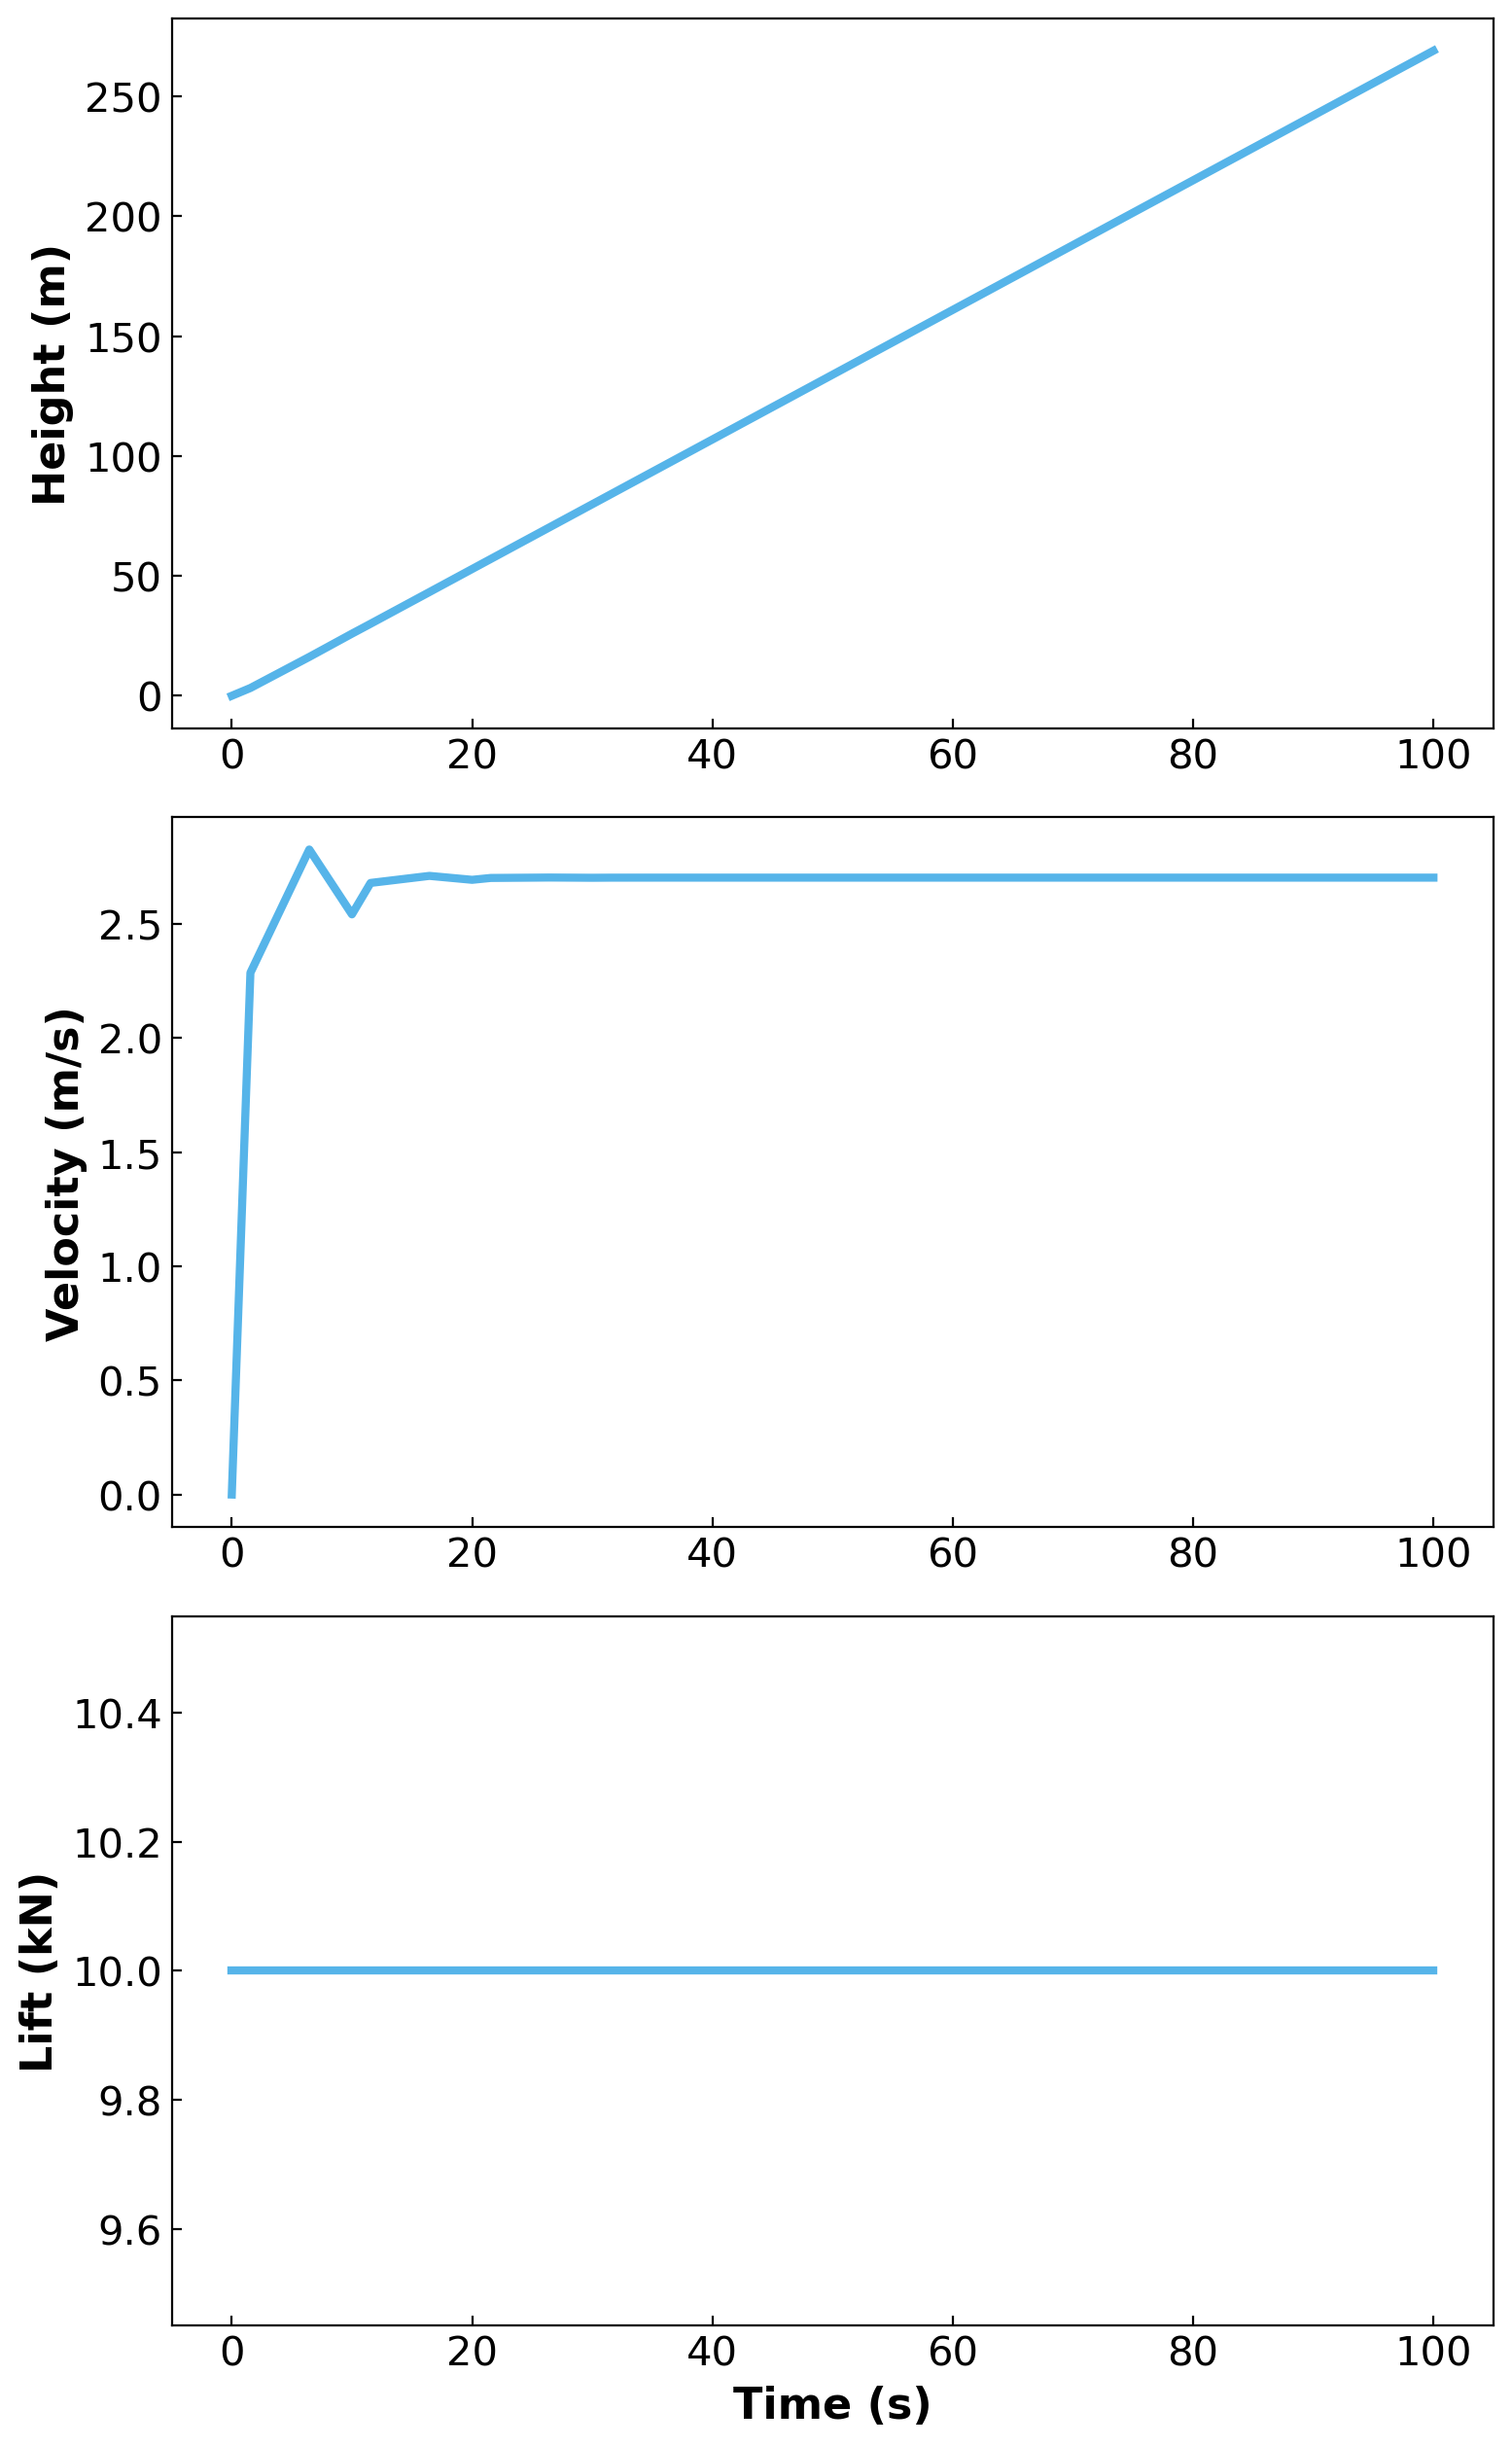

In [5]:
# Create a Model Instance
model = create_balloon_model_v0()

# Specify Number of Finite Elements
NFE = 10

# Call the Discretization/Initialization Function
discretize_initialize(model, NFE)

# Call the Solve Function
model = solve_model(model)

# Plot the Results
visualize_model(model)


###  Version 1: Correcting the Drag Force Calculation

After creating the base model, we noticed a potential problem in the Drag Force calculation. According to the drag force calculation using $y^2$, the value of drag will always be subtracted from the other forces.

After consulting with Dr. Dowling, drag calculation was adjusted to what is shown in the next iteration of the model, using $D = b|v|v$. Absolute value is not continuous, having a discontinuity at 0, so to model in Pyomo, we adjusted to make the function continuous by making $|v| = \sqrt{v^2 + eps}$ to take away the singularity at zero.

\begin{align*}
\max ~~ & 0 \\
\mathrm{s.t.}~~ & \frac{dh}{dt} = v(t) \\
 & D(t) = b \cdot v(t) \sqrt{v(t)^2 + \epsilon^2} \\
 & \frac{dv}{dt} \cdot m = L(t) - m \cdot g - D(t)  \\
 & h(t_0) = 0 \\
 & v(t_0) = 0 \\
 & L(t) = L_{ramp} = 10000, \quad \forall t \in [t_0, t_f]
\end{align*}



In [6]:
# Set-Up our Model as Function
def create_balloon_model_v1():

    ''' Modified from v0. Fixed drag.'''

    # Define a value ~0 to Help Stabilize the Drag Force Differential Equation
    eps = 1e-6

    # Create a Pyomo Model
    m = pyo.ConcreteModel('Hot Air Balloon')

    # Define time Domain
    m.t = dae.ContinuousSet(bounds=(0, 100))

    # Define State Variables as Functions of Time
    m.h = pyo.Var(m.t, bounds=(0, None))
    m.v = pyo.Var(m.t)
    m.D = pyo.Var(m.t)

    # Define Fixed Control Input
    m.L = pyo.Var(m.t, initialize=500)

    # Define derivatives
    m.dhdt = dae.DerivativeVar(m.h, wrt=m.t)
    m.dvdt = dae.DerivativeVar(m.v, wrt=m.t)


    # Reformulate m.D to Add Stability
    def drag_con(m, t):
        return m.D[t] == b*(m.v[t]**2 + eps**2)**(1/2)*m.v[t]
    m.drag_con = pyo.Constraint(m.t, rule=drag_con)

    # Define Differential Constraints
    def dh_con(m, t):
        return m.dhdt[t] == m.v[t]
    m.dh_con = pyo.Constraint(m.t, rule=dh_con)

    def dv_con(m, t):
        return m.dvdt[t]*m_balloon == m.L[t] - m_balloon*g - m.D[t]
    m.dv_con = pyo.Constraint(m.t, rule=dv_con)

    # Define L

    def l_con(m, t):
        return m.L[t] == 10000
    m.l_con = pyo.Constraint(m.t, rule=l_con)

    return m

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

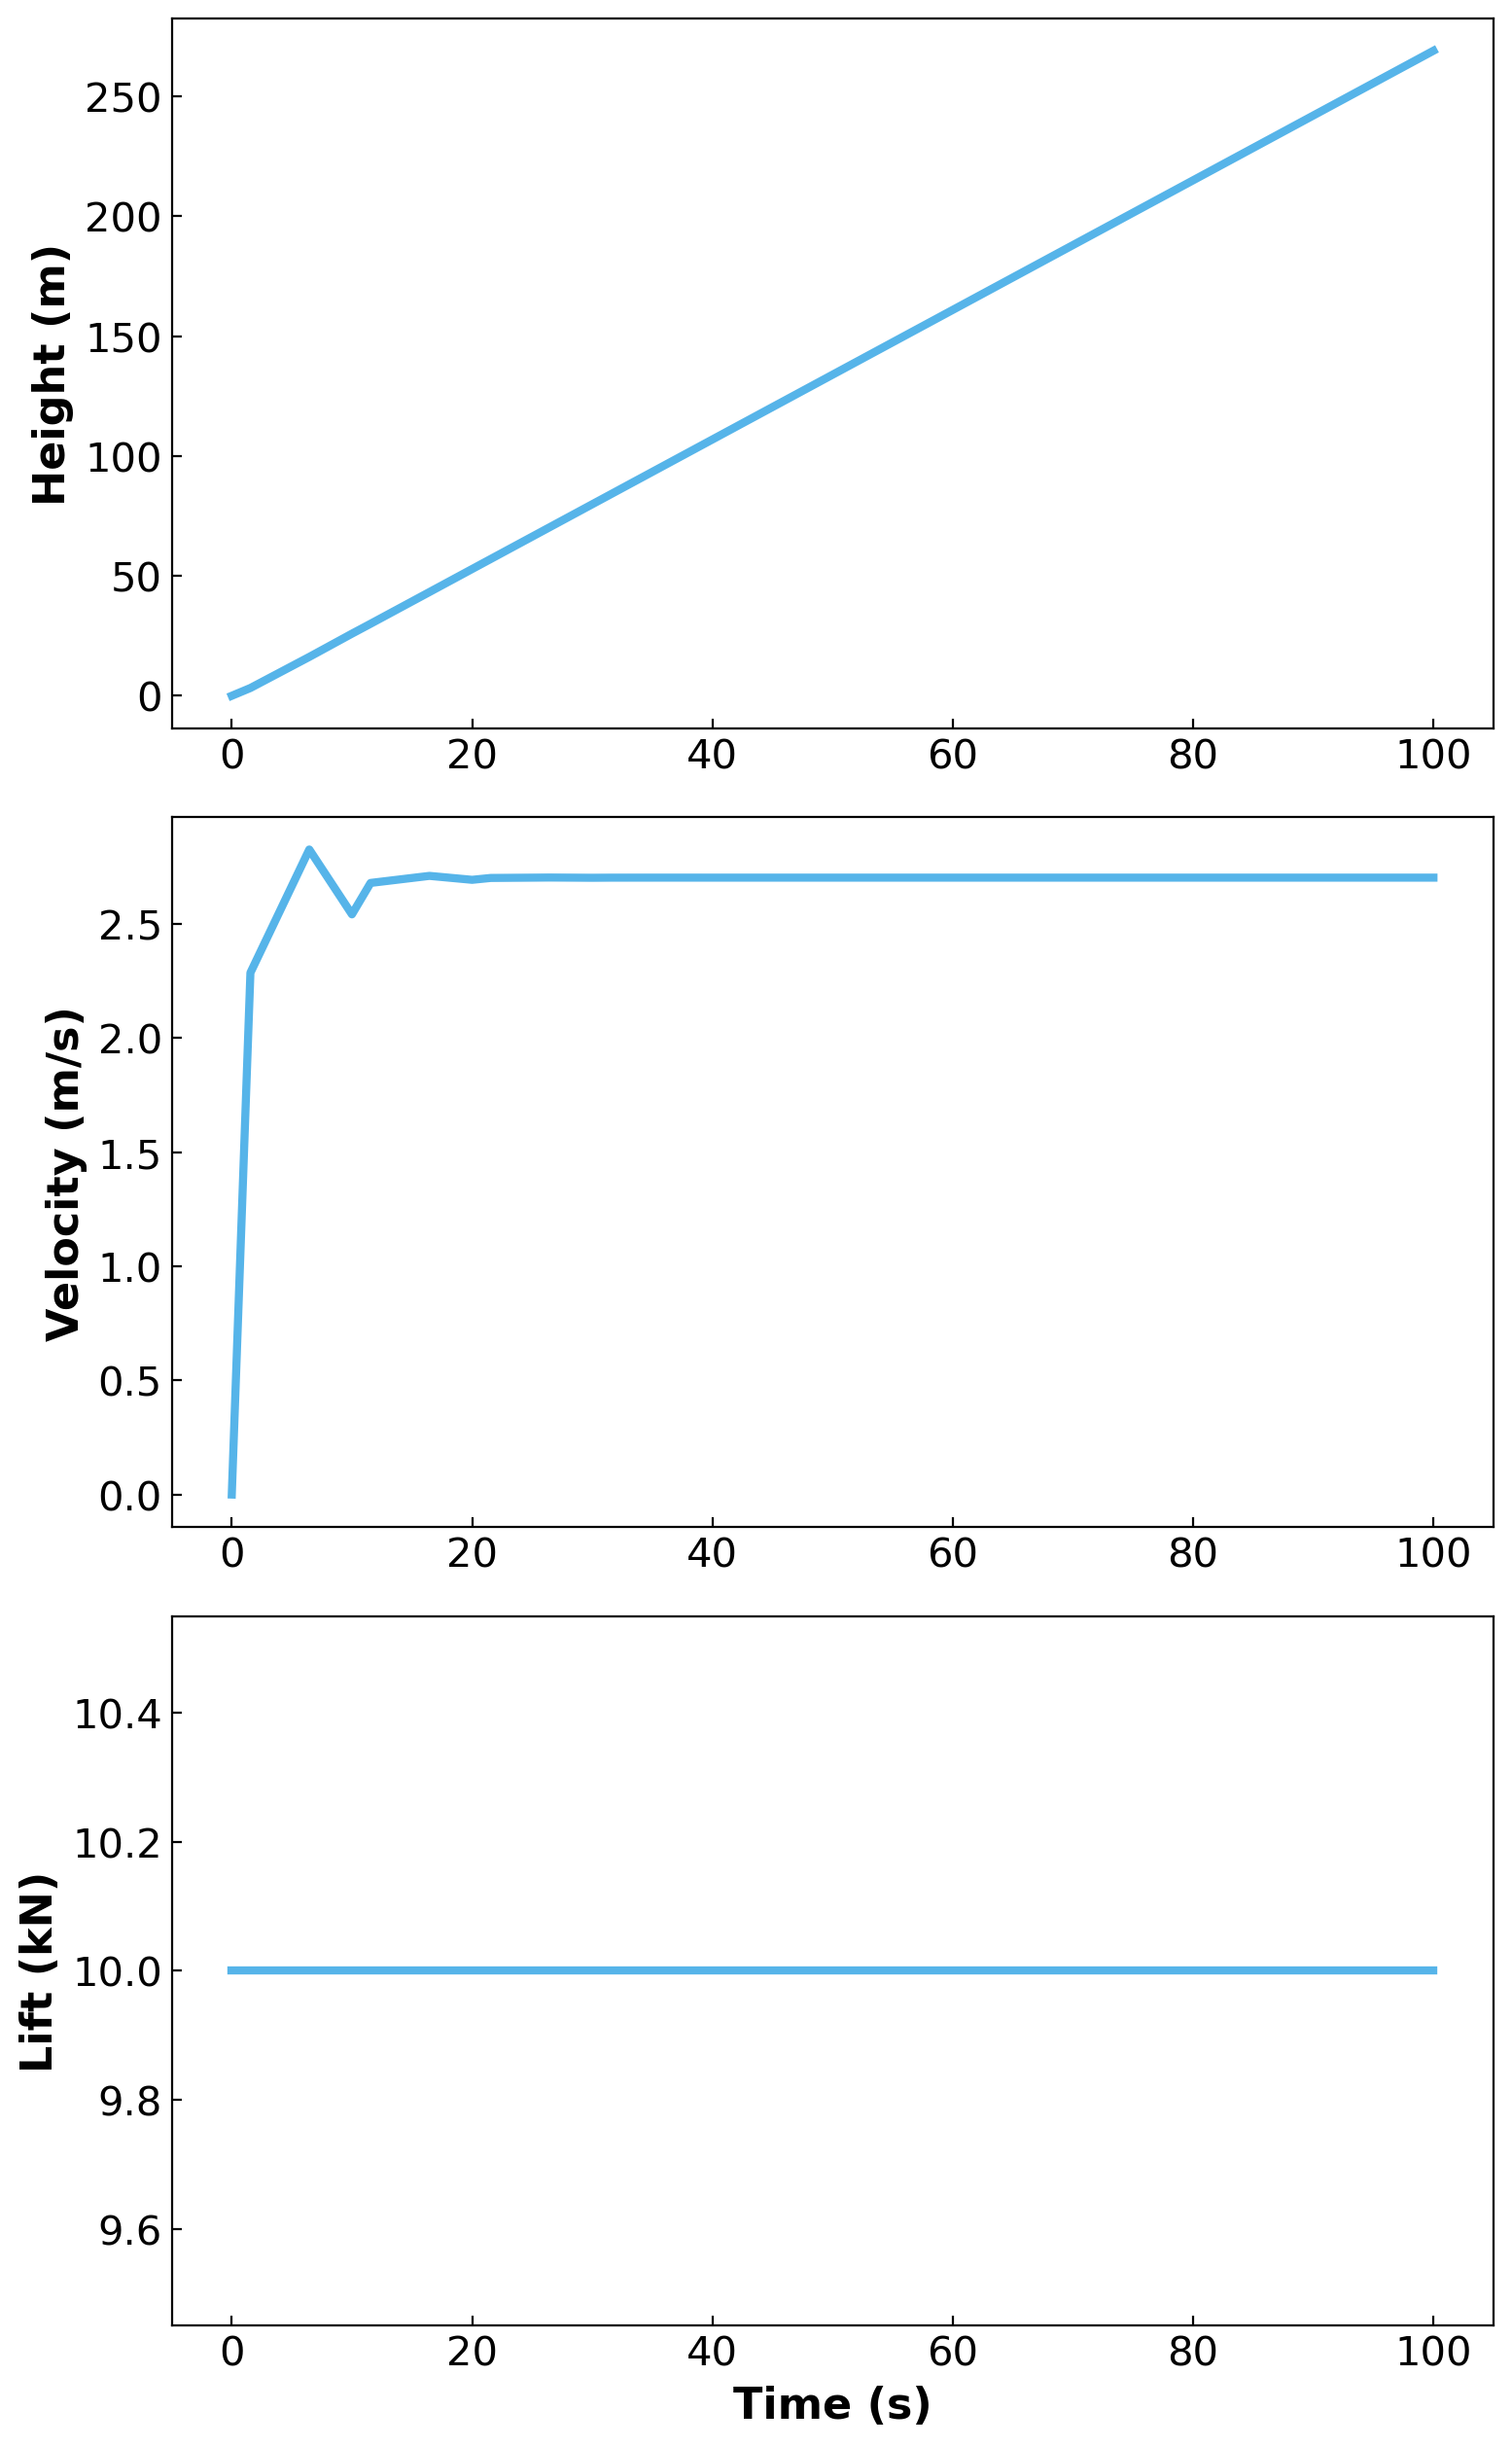

In [7]:
# Create a Model Instance
model = create_balloon_model_v1()

# Call the Discretization/Initialization Function
discretize_initialize(model, NFE)

# Call the Solve Function
model = solve_model(model)

# Visualize solution
fig, axs = visualize_model(model)

In [8]:
# Uncomment to view model printout after solving
# model.pprint()

## Analysis of Model Results: Varying Fixed Lift Value

### How does the set lift affect the velocity?

In [9]:
# Set-Up our Model as Function
def create_balloon_model_v1b():

    ''' Modified from v0. Fixed drag, made m.L a mutable parameter.'''

    # Define a Samll Constant to Help Stablize the Drag Force Differential Equation
    eps = 1e-6

    # Create a Pyomo Model
    m = pyo.ConcreteModel('Hot Air Balloon')

    # Define time Domain
    m.t = dae.ContinuousSet(bounds=(0, 100))

    #Define State Variables as Functions of Time
    m.h = pyo.Var(m.t, bounds=(0, None))
    m.v = pyo.Var(m.t)
    m.D = pyo.Var(m.t)

    #Define Fixed Control Input
    m.L = pyo.Param(initialize=10000, mutable = True)

    # Define derivatives
    m.dhdt = dae.DerivativeVar(m.h, wrt=m.t)
    m.dvdt = dae.DerivativeVar(m.v, wrt=m.t)


    # Reformulate m.D to Add Stability

    def drag_con(m, t):
        return m.D[t] == b*(m.v[t]**2 + eps**2)**(1/2)*m.v[t]
    m.drag_con = pyo.Constraint(m.t, rule=drag_con)

    # Define Differential Constraints
    def dh_con(m, t):
        return m.dhdt[t] == m.v[t]
    m.dh_con = pyo.Constraint(m.t, rule=dh_con)

    def dv_con(m, t):
        return m.dvdt[t]*m_balloon == m.L - m_balloon*g - m.D[t]
    m.dv_con = pyo.Constraint(m.t, rule=dv_con)

    return m

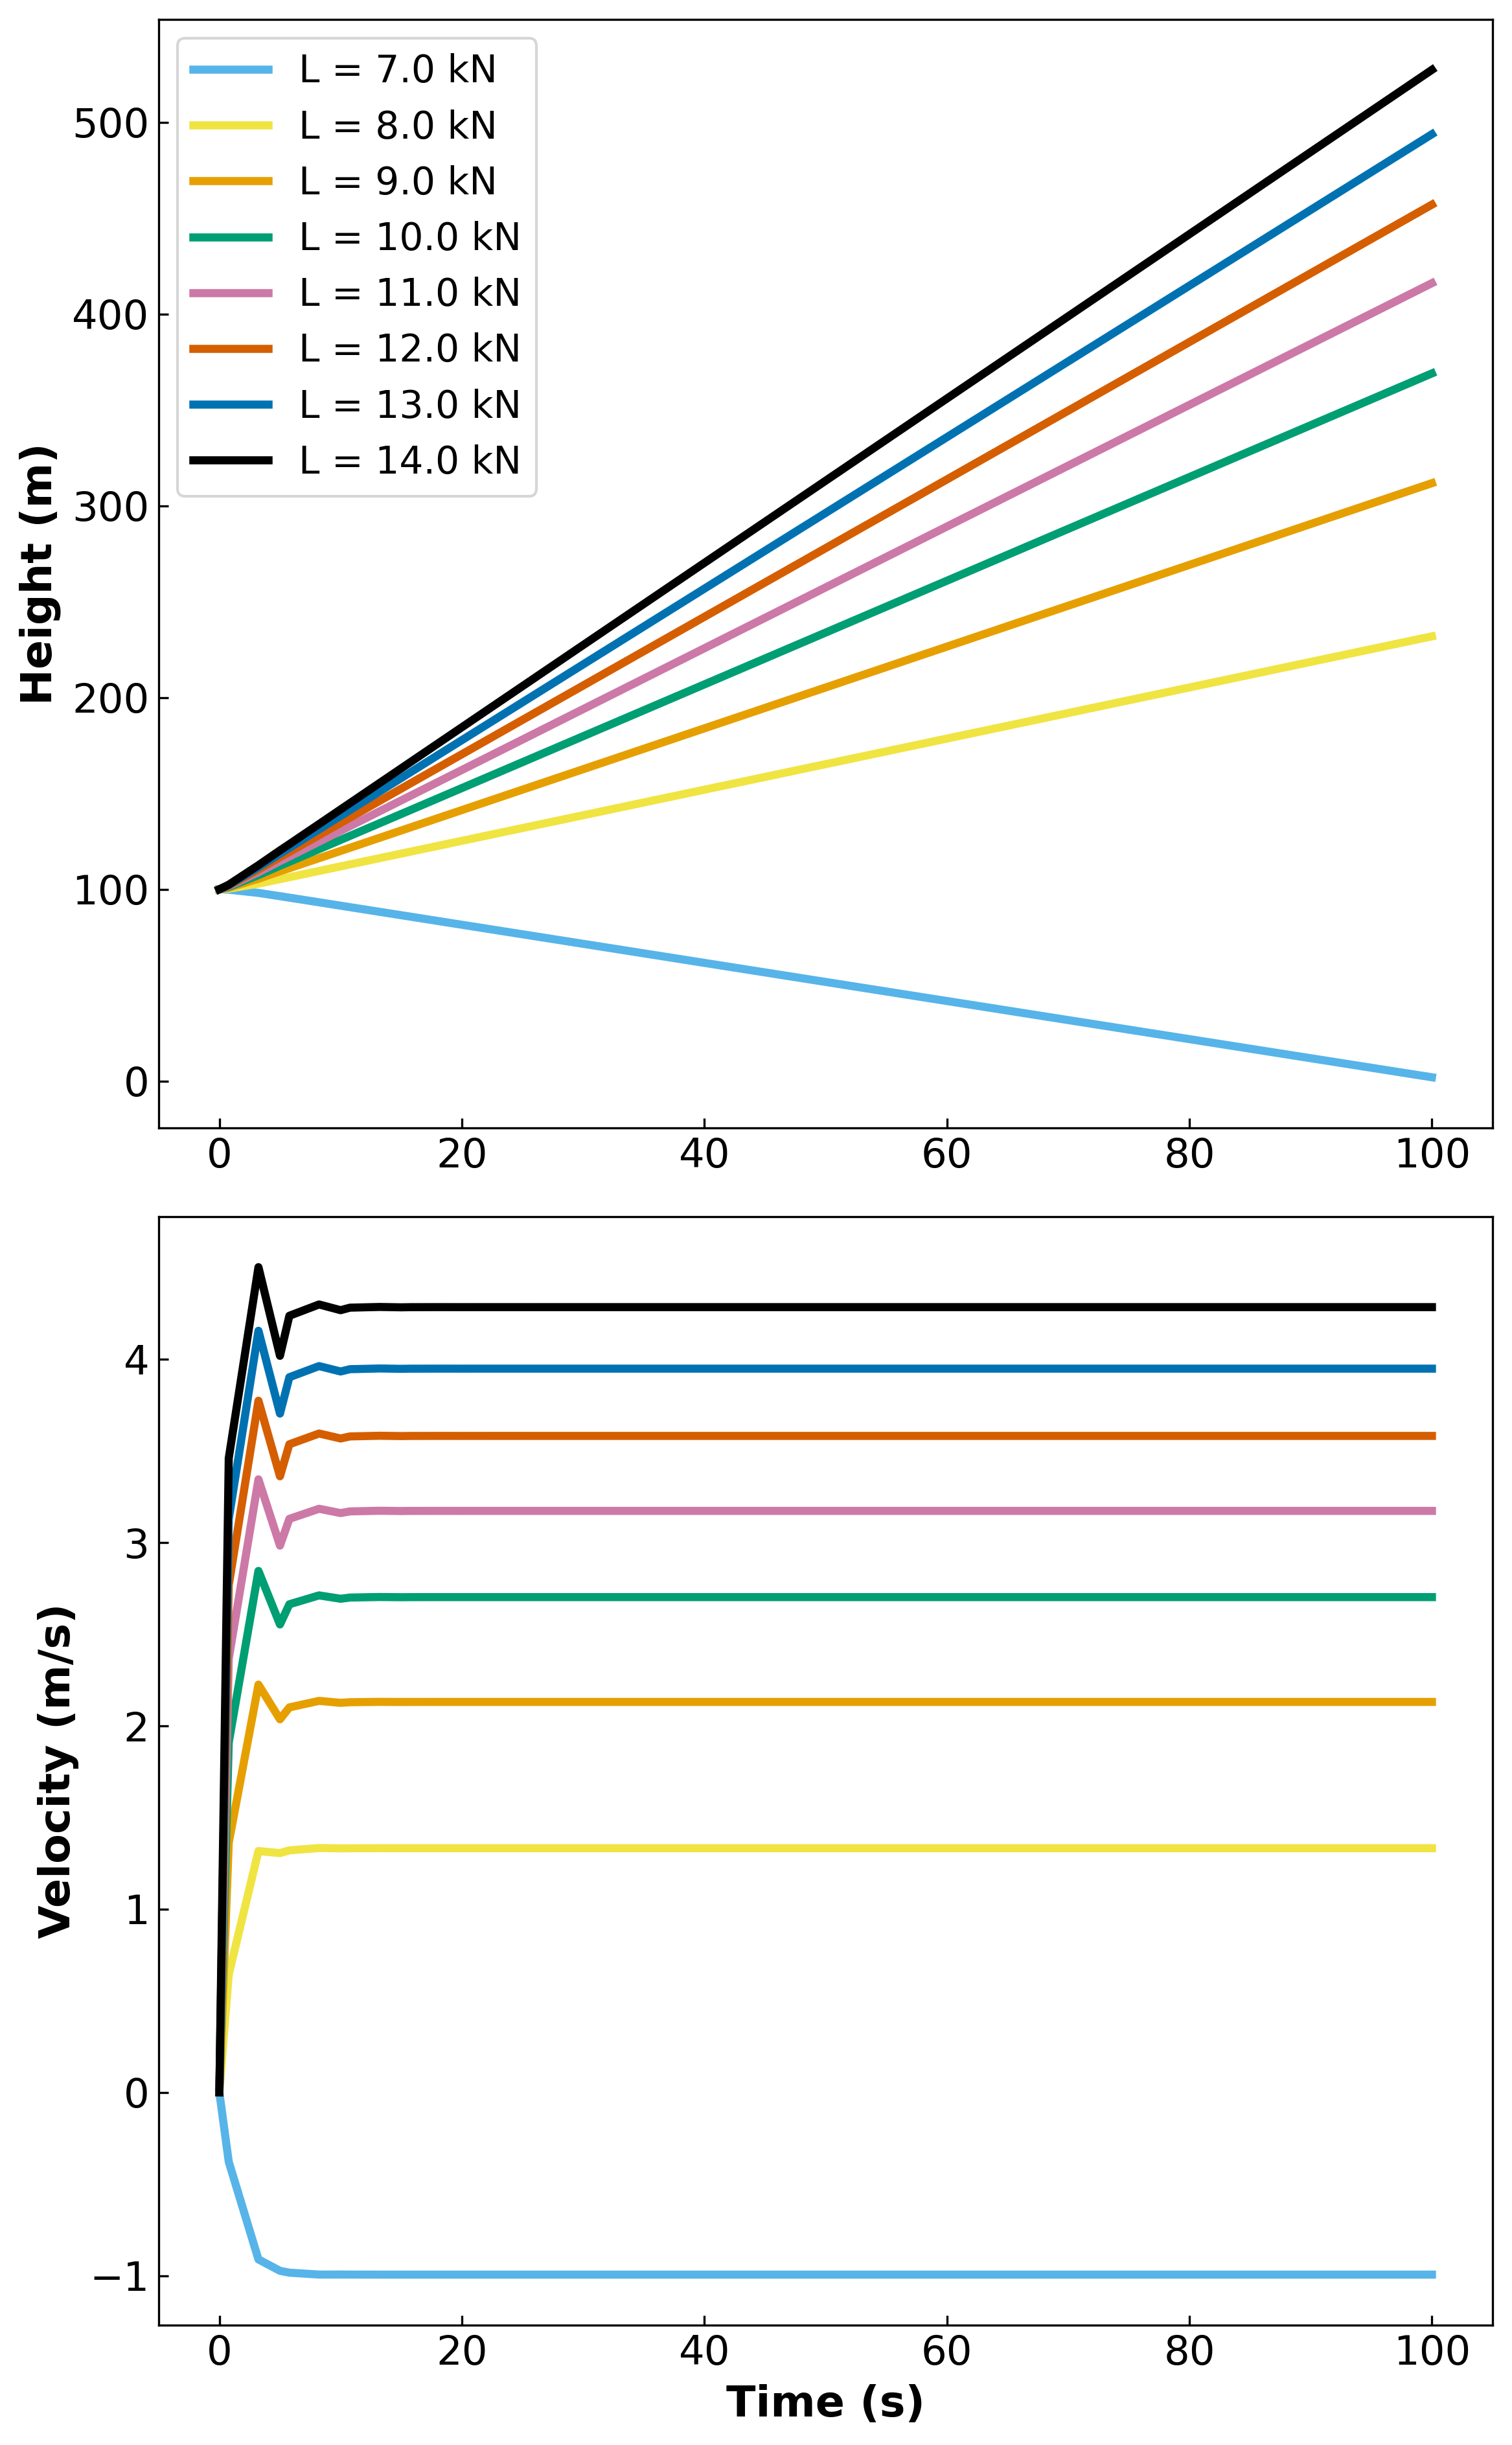

In [10]:
# Create a Model Instance
m = create_balloon_model_v1b()
nfe = 20

# Discretize
# Transform the Model using the 'dae.collocation' strategy.
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(m, nfe=nfe, wrt=m.t)

# Set initial conditions
m.h[0].fix(100) # Setting initial height above 0 to allow negative movement
m.v[0].fix(0)

fig, axs = plt.subplots(2, 1, dpi = 300, figsize=(8, 12.8))
colors = okabeito_list

lift_range = np.linspace(7, 14, 8)
count = 0
for i in lift_range:
    # print(i) Uncomment to print lift_range[i] and track progress
    m.L = i*1000
    m = solve_model(m, tee = False)
    t = [j for j in m.t]
    h = [m.h[j]() for j in m.t]
    v = [m.v[j]() for j in m.t]
    axs[0].plot(t, h, linewidth = 3, label = f'L = {i} kN', color = colors[count])
    axs[1].plot(t, v, linewidth = 3, color = colors[count])
    plt.xlabel('Time (s)', fontweight = 'bold', fontsize = 16)
    axs[0].set_ylabel('Height (m)', fontweight = 'bold', fontsize = 16)
    axs[1].set_ylabel('Velocity (m/s)', fontweight = 'bold', fontsize = 16)
    count += 1

axs[0].legend()
axs[0].tick_params(direction = 'in', labelsize=15)
axs[1].tick_params(direction = 'in', labelsize=15)
plt.tight_layout()
plt.show()

**Do these results make sense?**

Let's do a quick calculation to check our work.
The lift force needs to be at least equal to the mass of the balloon, which is set to 750 kg. Therefore, the value needs to be at least (750 kg) * (9.81 m/s^2), or ~ 7360 N. We decided to use a value of 10,000 N to see the balloon reach a constant velocity.

To estimate the result of the solver, we calculate the velocity achieved by setting the Equation 1 = 0 for the force balance on the balloon. We then derived the velocity.

\begin{align*}
 & 0 = L - mg - bv^2 \\
 & v = (\frac{L - mg}{b})^{0.5}  \\
\end{align*}

So with the known values of L, mg, and b, the velocity should be 2.7 m/s. This matches the resulting value from the solved model (green line).

## Model Formulation - Minimize ISE Objective

The next phase of model development involving adding a reference height or path and having the model objective be to minimize the integral of squared error between the height at each model step and the reference.

\begin{align*}
\min_{u(t)} ~~ & \int_{t_0}^{t_f} \|~h(t) - r(t)~\|^2\,dt \\
\mathrm{s.t.}~~ & \frac{dh}{dt} = v(t) \\
 & D(t) = b \cdot v(t) \sqrt{v(t)^2 + \epsilon^2} \\
 & \frac{dv}{dt} \cdot m = L(t) - m \cdot g - D(t)  \\
 & h(t_0) = 0 \\
 & v(t_0) = 0 \\
 & L(t_0) = 10000
\end{align*}

### Degree of Freedom Analysis

**Versions 2 --> 4**

In model formulations for versions 2, 3, and 4, the lift force is now treated as a variable with respect to time and is no longer fixed. Lift became the control variable and added a degree of freedom to our system.

Variables: h(t) , v(t) , D(t) , L(t)
Number of Constraints: 3

$ DOF = 4-3 = 0 $

Versions 2 through 4 of our model have 1 DOF allowing the optimizer to freely manipulate our decision variable.

### Version 2: Reach a Desired Final Height

\begin{align*}
\min_{u(t)} ~~ & \int_{t_0}^{t_f} \|~h(t_f) - h_{desired}~\|^2\,dt \\
\mathrm{s.t.}~~ & \frac{dh}{dt} = v(t) \\
 & D(t) = b \cdot v(t) \sqrt{v(t)^2 + \epsilon^2} \\
 & \frac{dv}{dt} \cdot m = L(t) - m \cdot g - D(t)  \\
 & h(t_0) = 0 \\
 & v(t_0) = 0 \\
 & L(t_0) = 10000
\end{align*}

In the next iteration of the model, we add an objective to minimize the sum of squared error (SSE) between a target height the height reached at the end of the model.

This is the first iteration containing the control variable being utilized as a variable in the model. Therefore, we needed to define reasonable bounds for the lift of our balloon.

The lift force, as stated in Engineering Toolbox, is defined by the following equation:
$ L[t] = V(ρ_{out} - ρ_{in}) \times g $

**Volume**:
We defined parameters regarding the balloon earlier in the notebook. In the referenced CHARM Lab balloon model, they chose to make a hemispherical balloon with a radius of 10 m. For this model, we made a fully spherical balloon of the same radius. So the volume of our balloon is $4/3*π*R^3$, or roughly 4190 $m^3$.

**Density**:
The density of air at 100°C (373.15 K) is approximately 0.946 $kg/m^3$, and at 20 °C is 1.205 $kg/m^3$.

**Gravity**:
We use the approximation of gravity $9.81 m/s^2$ in all relevant notebook calculations.

For the maximum value of lift, we use the lift force calculation with our size balloon.

For the minimum value, we chose a limiting velocity of -2 $m/s$ for the descent of the balloon, and calculated the lift force required to maintain that velocity using the model equations.

$ v = (\frac{L - mg}{b})^{0.5} $

$ L = bv^2 + mg $


In [11]:
# Calculating bounds for L
V = 4/3 * np.pi * radius**3
L_ub = V*(rho_air-0.946)*g
print(f'V = {np.round(V, 2)} m^3')
print(f'L_ub = {np.round(L_ub, 2)} N')

L_lb = b*-1*(2)**2 + m_balloon*g
print(f'L_lb = {np.round(L_lb, 2)} N')


V = 4188.79 m^3
L_ub = 11464.68 N
L_lb = 5910.48 N


In [12]:
def create_balloon_model_v2(height_ref):
    ''' Fixed drag, added objective for difference of final height from height ref, sqaured.

    Input:
        height_ref: Reference desired final height (m).

        Returns:
        m: Initial model v2.
        '''

    # Set a Target Height
    desired_height = height_ref
    endtime = 200

    # Define a Small Constant to Help Stabilize the Drag Force Constraint
    eps = 1e-6

    # Create a Pyomo Model
    m = pyo.ConcreteModel('Hot Air Balloon')

    # Define Time Domain
    m.t = dae.ContinuousSet(bounds=(0, endtime))

    # Define State Variables as Function of Time
    m.h = pyo.Var(m.t, bounds=(0, None))
    m.v = pyo.Var(m.t, bounds=(-2, 5))
    m.D = pyo.Var(m.t)

    # Define Control Variable (Lift) as a Function of Time
    m.L = pyo.Var(m.t, bounds=(L_lb, L_ub))

    # Define Derivative Variables
    m.dhdt = dae.DerivativeVar(m.h, wrt=m.t)
    m.dvdt = dae.DerivativeVar(m.v, wrt=m.t)

    # Define Derivative Constraints
    # Height derivative constraint (dh/dt = v)
    def dh_con(m, t):
        return m.dhdt[t] == m.v[t]
    m.dh_con = pyo.Constraint(m.t, rule=dh_con)

    # Velocity derivative, acceleration constraint (m * dv/dt = L - mg - D)
    def dv_con(m, t):
        return m.dvdt[t] * m_balloon == m.L[t] - m_balloon * g - m.D[t]
    m.dv_con = pyo.Constraint(m.t, rule=dv_con)

    # Drag force calculation (D = b * v^2)
    def drag_con(m, t):
        return m.D[t] == b * (m.v[t]**2 + eps**2)**(1/2) * m.v[t]
    m.drag_con = pyo.Constraint(m.t, rule=drag_con)

    # Set Initial conditions
    m.h[0].fix(0)
    m.v[0].fix(0)
    m.L[0].fix(10000)

    # Define the objective: Minimize the difference between final height and the desired height
    def objective_rule(m):
        return (m.h[endtime] - desired_height)**2  # Minimize squared difference at final time
    m.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

    return m


(<Figure size 1600x2560 with 3 Axes>,
 array([<Axes: ylabel='Height (m)'>, <Axes: ylabel='Velocity (m/s)'>,
        <Axes: xlabel='Time (s)', ylabel='Lift (kN)'>], dtype=object))

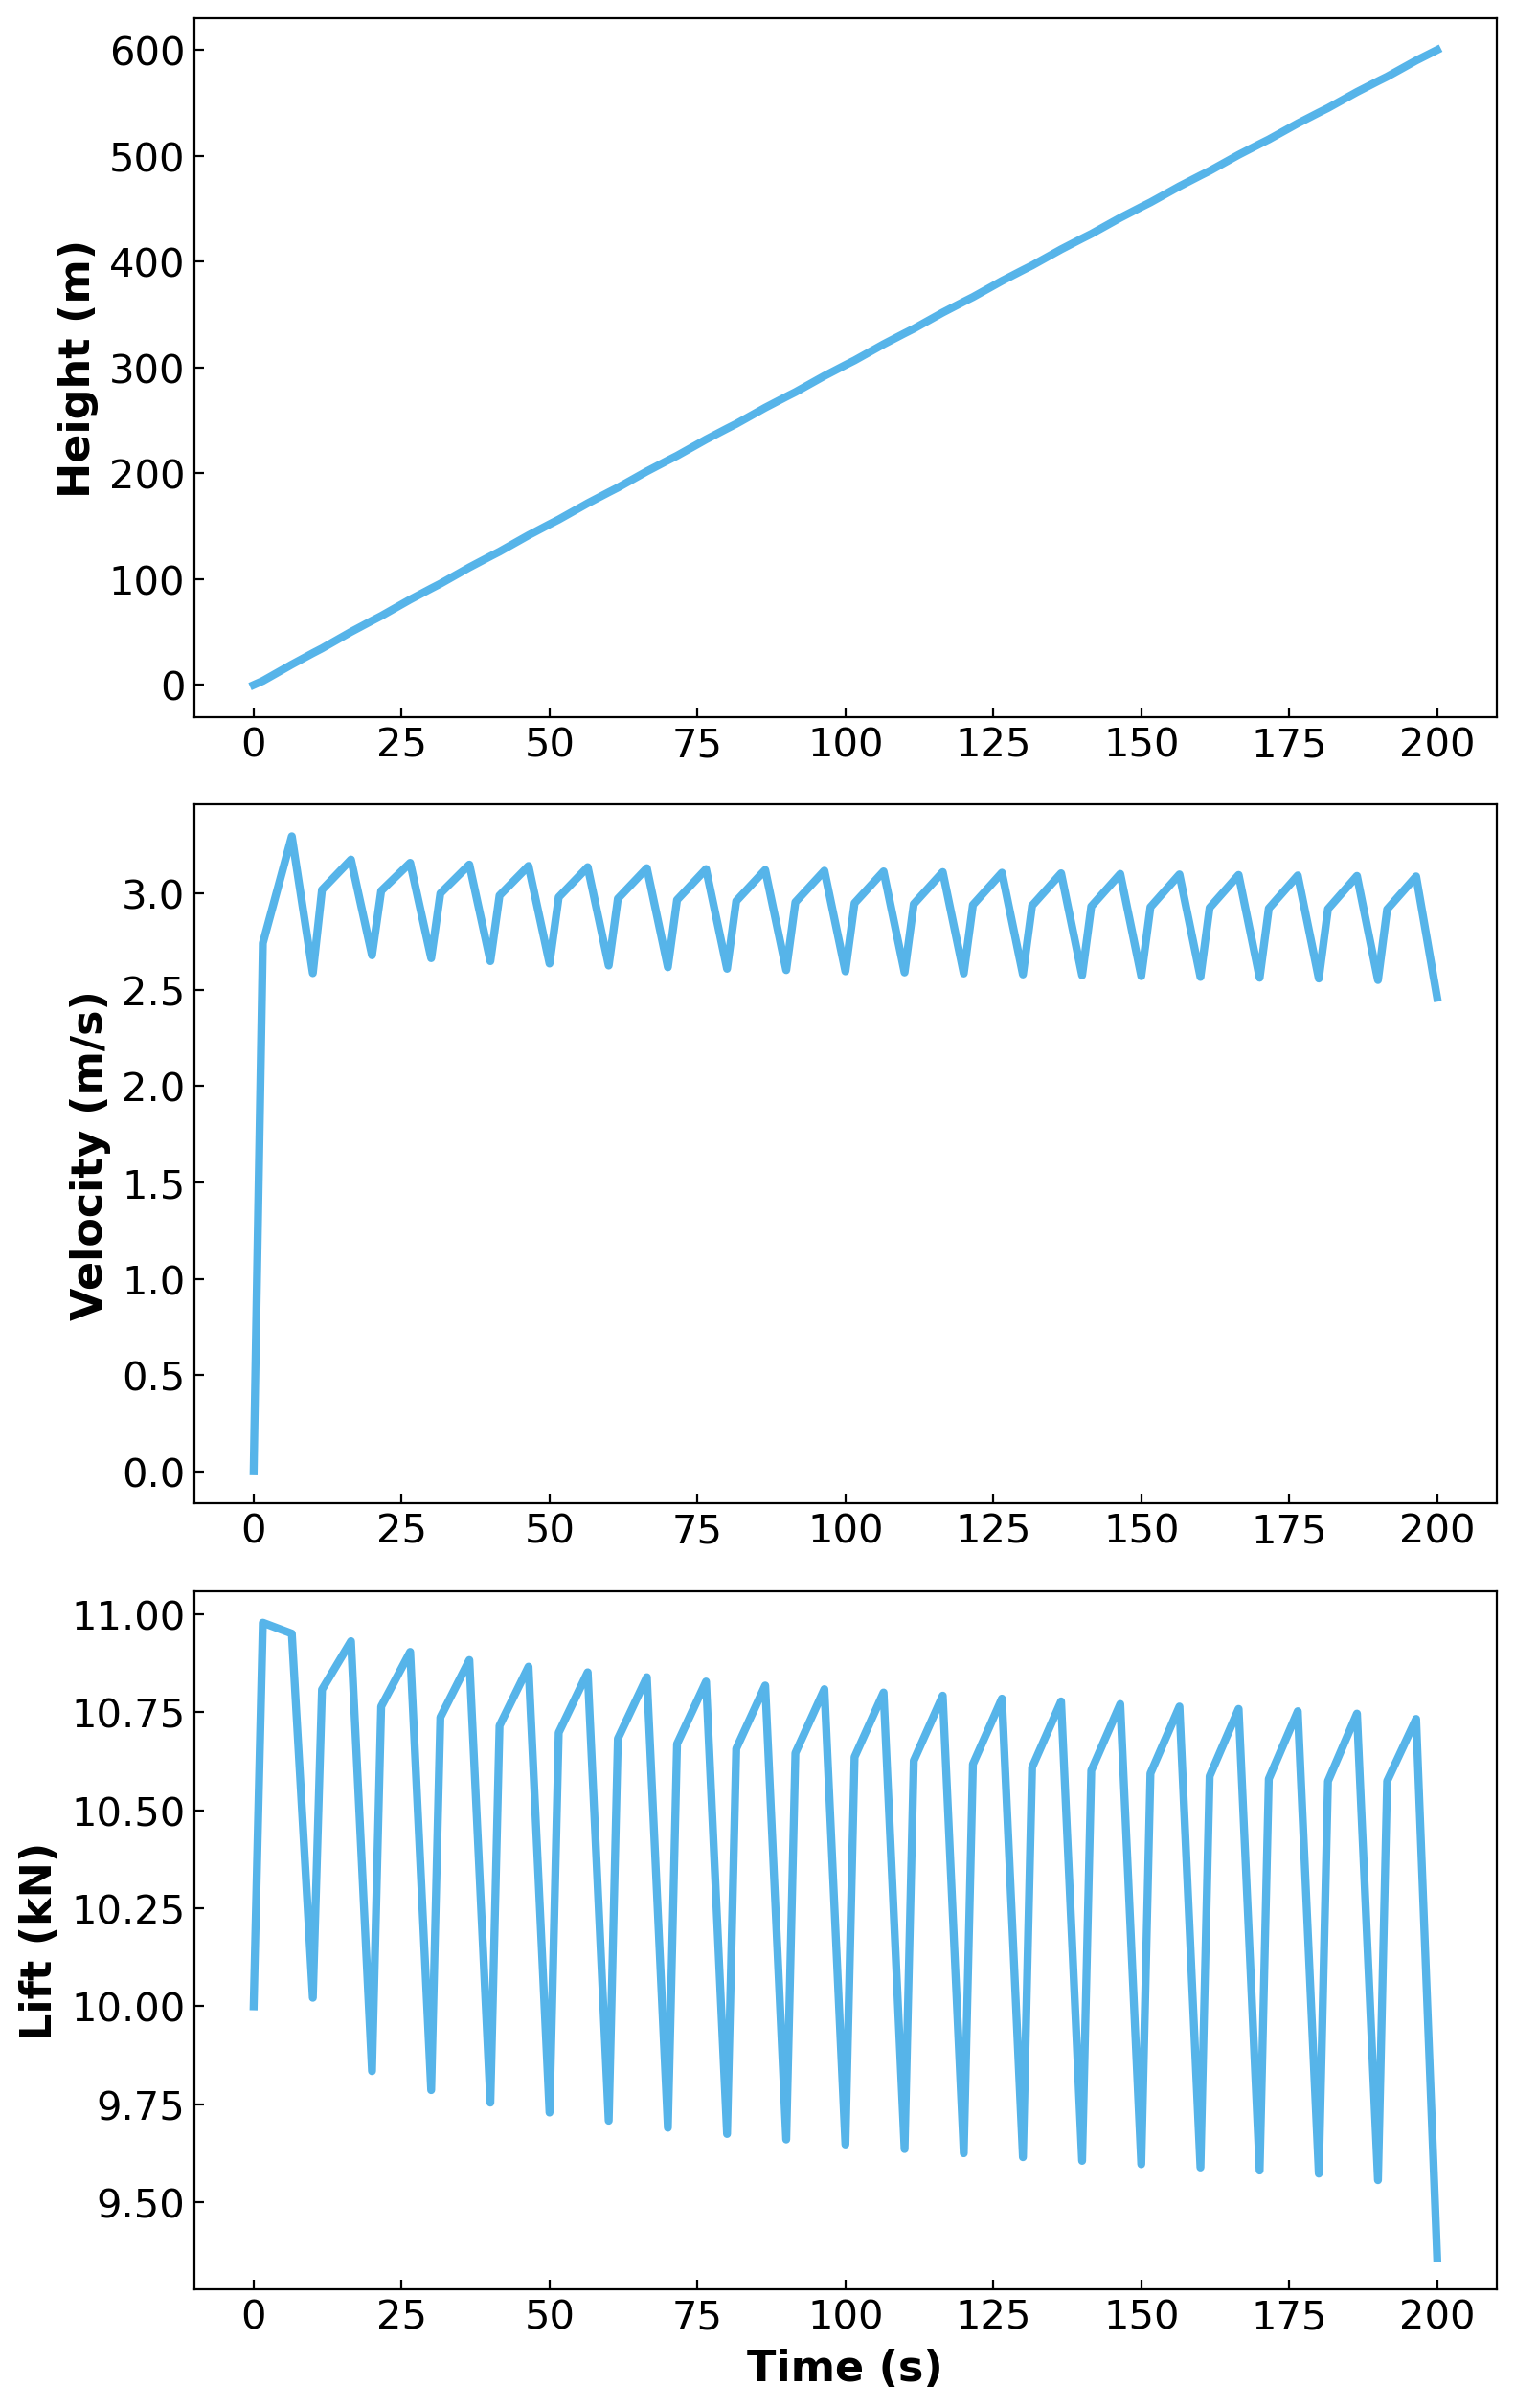

In [13]:
# Create a Model Instance
ref_height = 600
NFE = 20
model = create_balloon_model_v2(ref_height)

# Call the Discretization/Initialization Function
discretize_initialize(model, NFE)

# Call the Solve Function
# To view Ipopt output, set tee = True
model = solve_model(model, tee = False)

# Visualize solution
visualize_model(model)

## Analysis of Model Results: Reach a Desired Final Height

### What is maximum achievable height in 200 seconds?





To answer this question, let's test a few reference heights in the version 2 model.

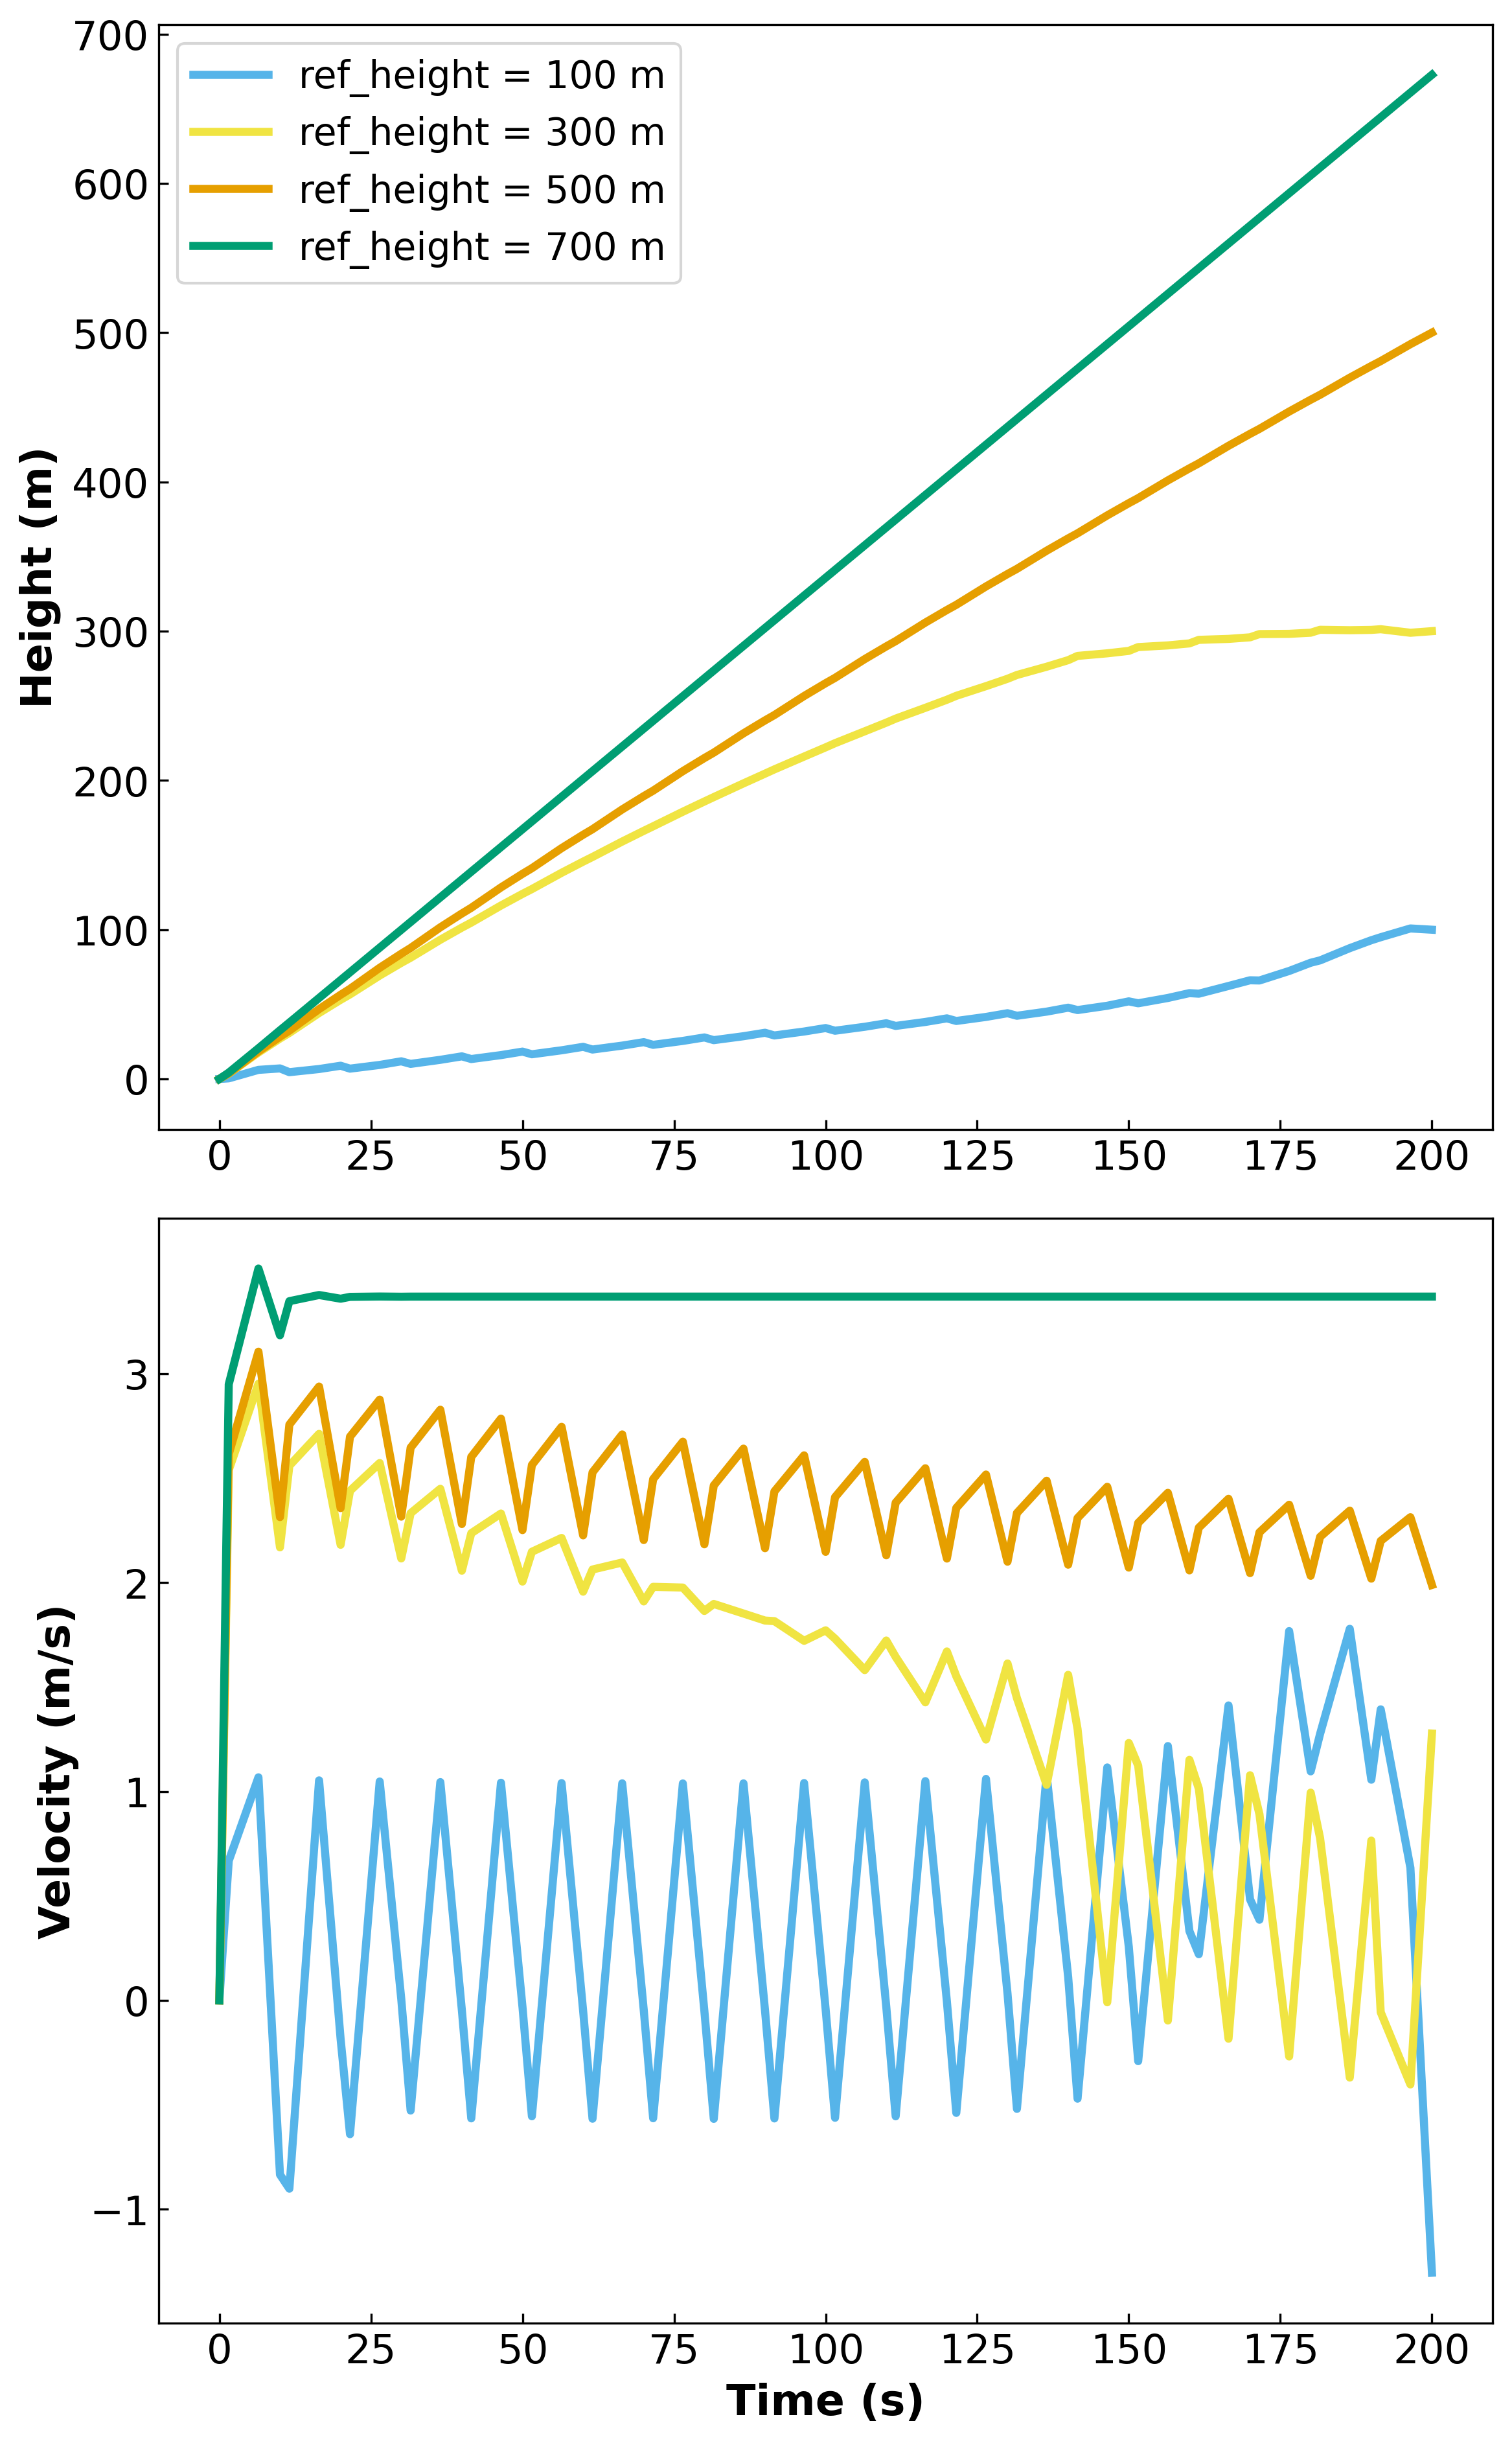

In [14]:
NFE = 20
count = 0

# Set figure to hold plots
fig, axs = plt.subplots(2, 1, dpi = 300, figsize=(8, 12.8))
colors = okabeito_list

# Assign reference heights
ref_heights = [100, 300, 500, 700]
for i in ref_heights:
    m = create_balloon_model_v2(i)
    discretize_initialize(m, NFE)
    solve_model(m, tee = False)
    t = [j for j in model.t]
    h = [m.h[j]() for j in m.t]
    v = [m.v[j]() for j in m.t]
    axs[0].plot(t, h, linewidth = 3, label = f'ref_height = {i} m', color = colors[count])
    axs[1].plot(t, v, linewidth = 3, color = colors[count])
    plt.xlabel('Time (s)', fontweight = 'bold', fontsize = 16)
    axs[0].set_ylabel('Height (m)', fontweight = 'bold', fontsize = 16)
    axs[1].set_ylabel('Velocity (m/s)', fontweight = 'bold', fontsize = 16)
    count += 1

# Format for publication quality
axs[0].legend()
axs[0].tick_params(direction = 'in', labelsize=15)
axs[1].tick_params(direction = 'in', labelsize=15)
plt.tight_layout()
plt.show()


From the graph, it looks like the maximum height is just under 700 m.

**Check our work**

With a quick calculation, let's check the model solution with a hand calculation. The maximum height would use the maximum allowable lift.

Using our upper bound for lift, and the derived velocity from earlier in the notebook, the velocity achievable would be:


In [15]:
# Maximum velocity uses maximum lift
max_v = ((L_ub - m_balloon*g)/b)**(0.5)
print(f'Maximum velocity = {np.round(max_v, 2)} m/s')

Maximum velocity = 3.37 m/s


The height would then be $ \int_{t_0}^{t_f} v(t) dt $,

or $t_f \times v(t) $ when $ t_0 = 0 $.

Therefore, the maximum calculated height should be approximately 674 m, matching the plotted result.

### Version 3: Follow a Linear Path

Now let's solve the optimal control problem to find a control policy $u(t)$ for the interval $t_0 \leq t \leq t_f$ which causes the output $T_H(t)$ to track a desired setpoint or reference tracjectory $SP(t)$.

\begin{align*}
\min_{L(t)} ~~ & \int_{t_0}^{t_f} \|~h(t) - r(t)~\|^2\,dt \\
\mathrm{s.t.}~~ & \frac{dh}{dt} = v(t) \\
 & D(t) = b \cdot v(t) \sqrt{v(t)^2 + \epsilon^2} \\
 & \frac{dv}{dt} \cdot m = L(t) - m \cdot g - D(t)  \\
 & h(t_0) = 0 \\
 & v(t_0) = 0 \\
 & L(t_0) = 10000
\end{align*}

For the first path, we have the model follow a linear trajectory up defined by a slope.

In [16]:
# make a controlled path up

def linear(t):
    ''' Linear function with slope 2.5.
    Inputs:
        t: Time (s)

    Returns
        2.5*t:'''

    return 2.5*t

In [17]:
def create_balloon_model_v3():
    ''' Fixed drag, added integrated squared error between model and reference function, objective to minimize ise.'''

    # Define a Samll Constant to Help Stabalize the Drag Force Differential Equation
    eps = 1e-6

    # Create a Pyomo Model
    m = pyo.ConcreteModel('Hot Air Balloon')

    # Define Time Domain
    m.t = dae.ContinuousSet(bounds=(0, tf))

    # Define State Variables as Function of Time
    m.h = pyo.Var(m.t, bounds=(0, None))
    m.v = pyo.Var(m.t)
    m.D = pyo.Var(m.t)

    # Define Control Variable (Lift) as a Function of Time
    m.L = pyo.Var(m.t, bounds = (L_lb, L_ub))

    # Define Derivative Variables
    m.dhdt = dae.DerivativeVar(m.h, wrt=m.t)
    m.dvdt = dae.DerivativeVar(m.v, wrt=m.t)

    # Define Derivative Constraints
    # Height derivative constraint (dh/dt = v)
    def dh_con(m, t):
        return m.dhdt[t] == m.v[t]
    m.dh_con = pyo.Constraint(m.t, rule=dh_con)

    # Velocity derivative, acceleration constraint (m * dv/dt = L - mg - D)
    def dv_con(m, t):
        return m.dvdt[t] * m_balloon == m.L[t] - m_balloon * g - m.D[t]
    m.dv_con = pyo.Constraint(m.t, rule=dv_con)

    # Drag force calculation (D = b * v^2)
    def drag_con(m, t):
        return m.D[t] == b * (m.v[t]**2 + eps**2)**(1/2) * m.v[t]
    m.drag_con = pyo.Constraint(m.t, rule=drag_con)

    # Set Initial conditions
    m.L[0].fix(10000)

    # Define the objective: Minimize the difference between final height and the desired height
    @m.Integral(m.t)
    def ise(m, t):
        return (m.h[t] - linear(t))**2  # Minimize squared difference at final time


    # Define the objective function
    @m.Objective(sense=pyo.minimize)
    def objective(m):
        return m.ise

    return m

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

(<Figure size 1600x2560 with 3 Axes>,
 array([<Axes: ylabel='Height (m)'>, <Axes: ylabel='Velocity (m/s)'>,
        <Axes: xlabel='Time (s)', ylabel='Lift (kN)'>], dtype=object))

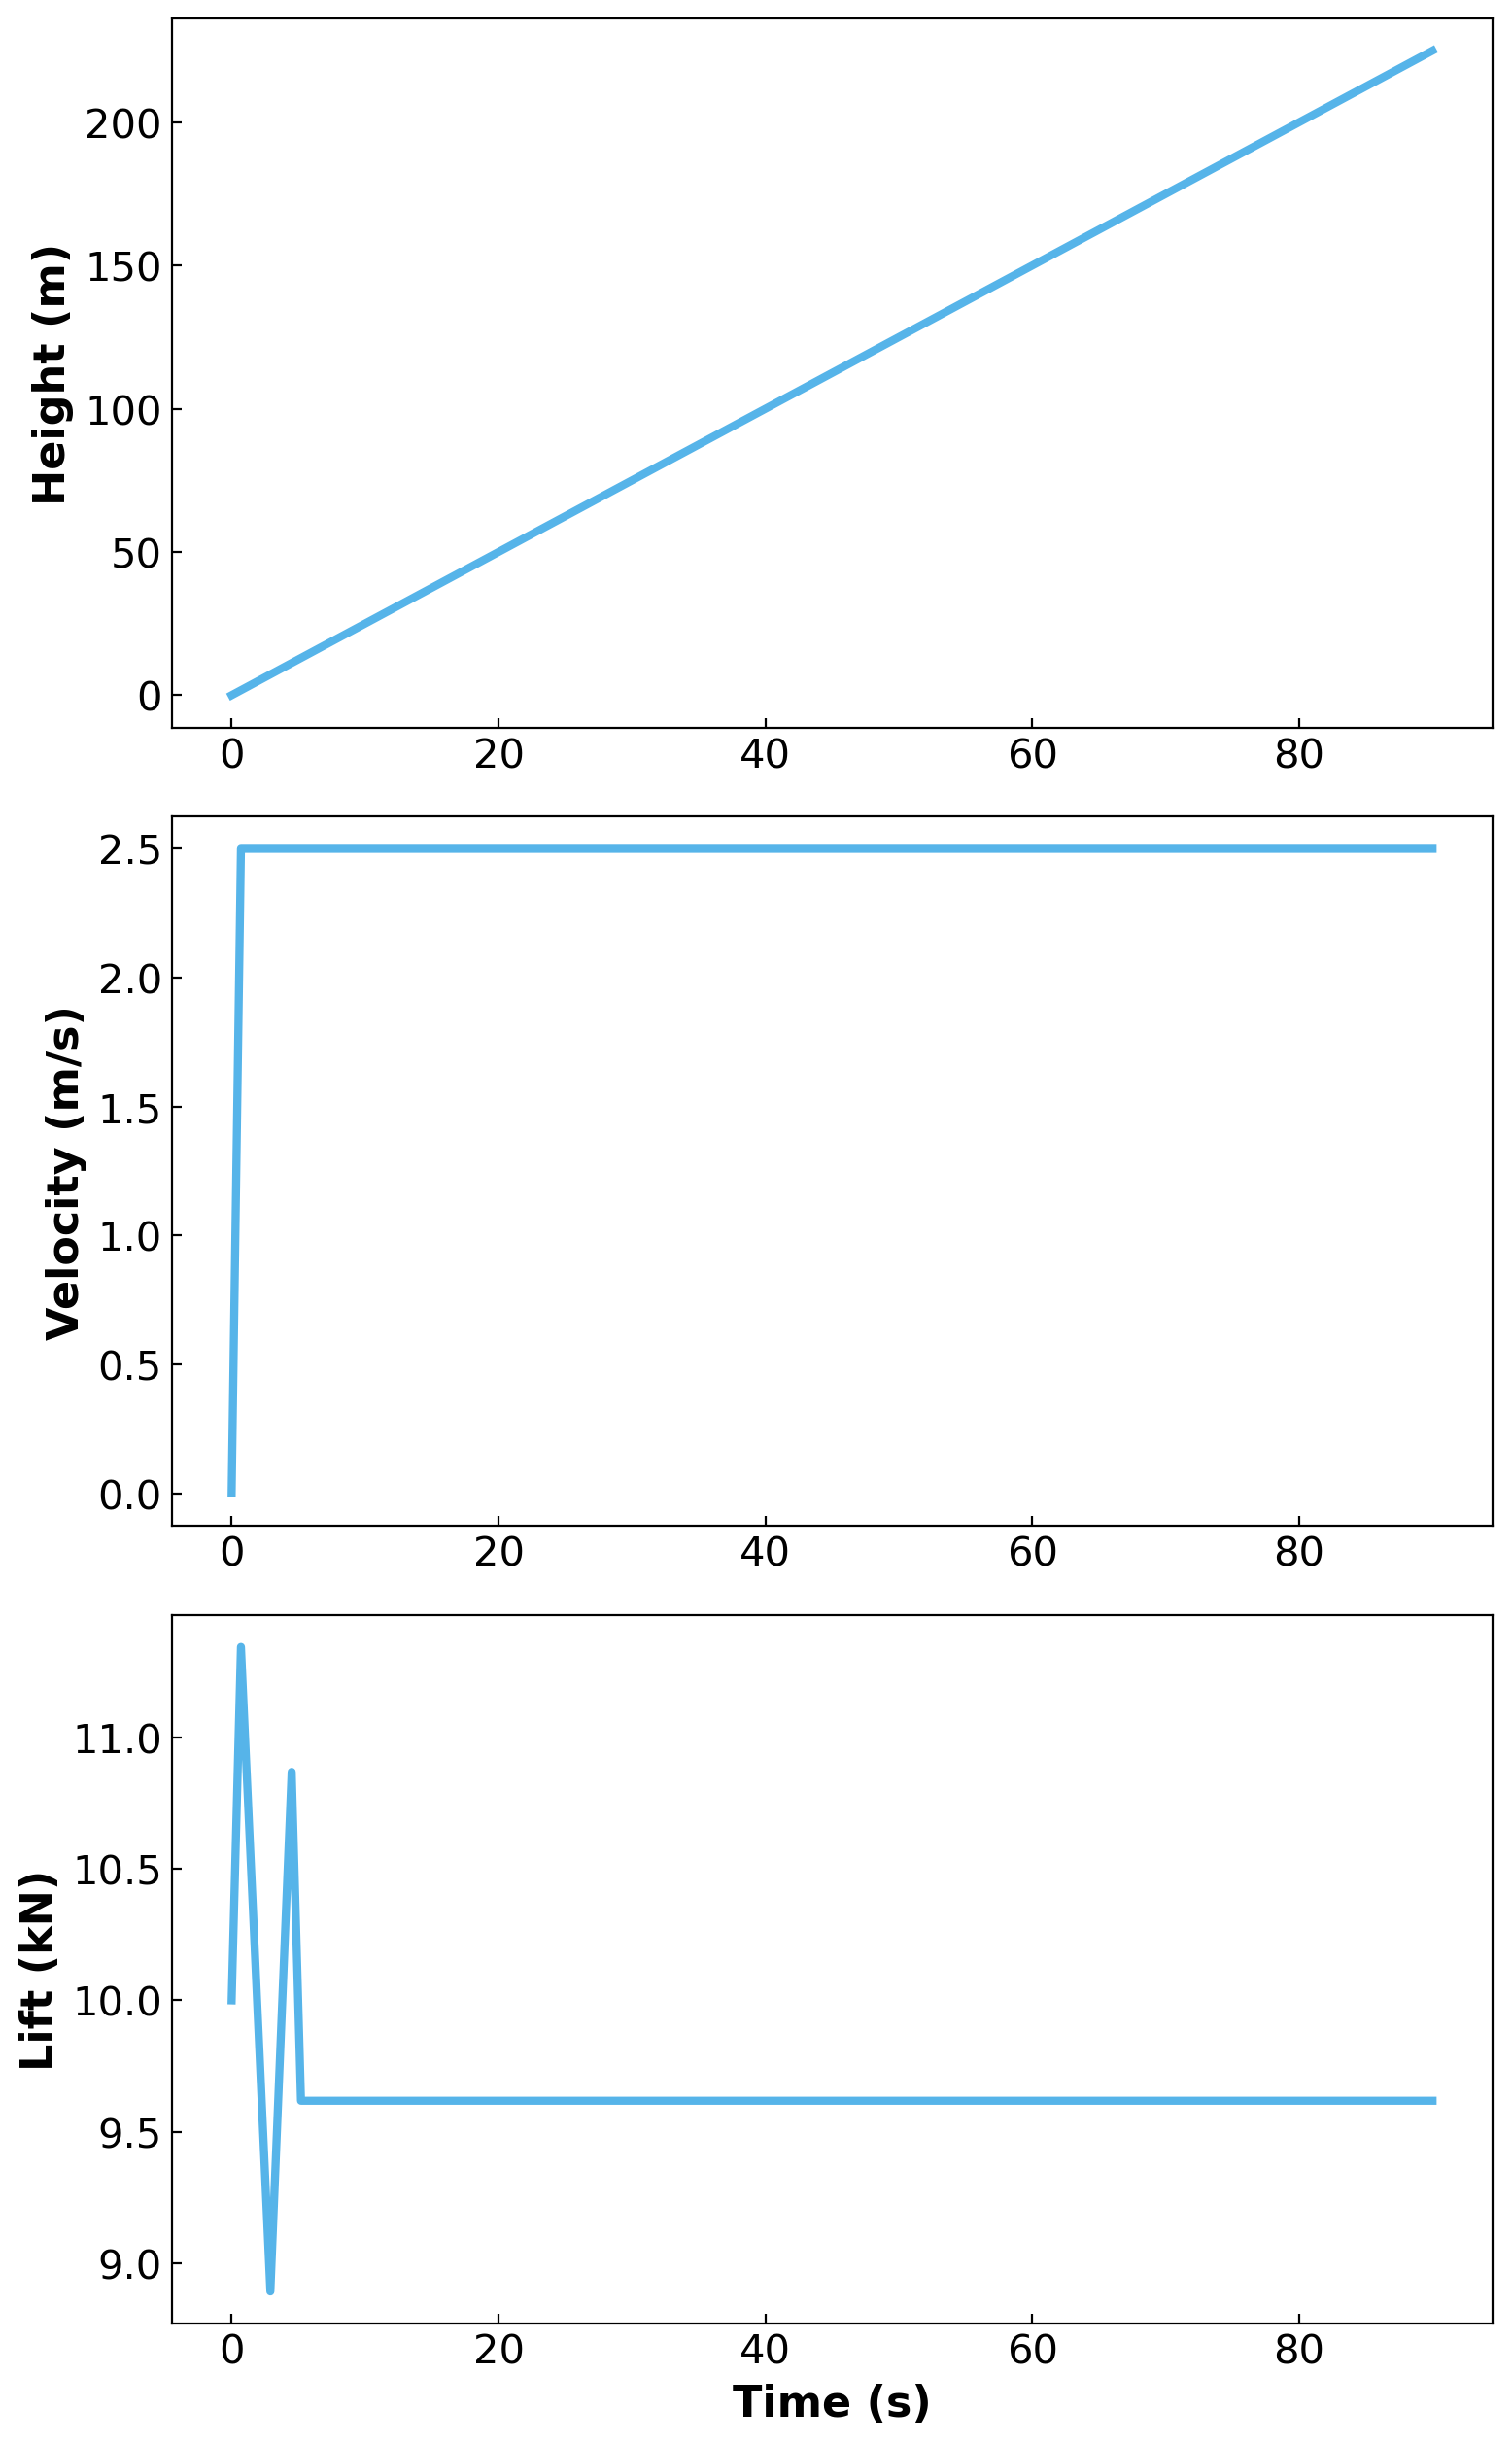

In [18]:
# Create a Model Instance
tf = 90
nfe = 20
model = create_balloon_model_v3()

# Call the Discretization/Initialization Function
discretize_initialize(model, NFE)

# Call the Solve Function
model = solve_model(model)

# Display the results
# for t in model.t:
#     # if t % 2 == 0:
#         print(f"Time {t}: Height = {pyo.value(model.h[t])}, Velocity = {pyo.value(model.v[t])}, Lift = {pyo.value(model.L[t])}")

# Visualize solution
visualize_model(model)

###  Version 4: Follow a Dynamic Flight Path

Lastly, we have the model follow a flight path containing multiple set heights and velocities.

First, using `np.interp`, we define the reference path.

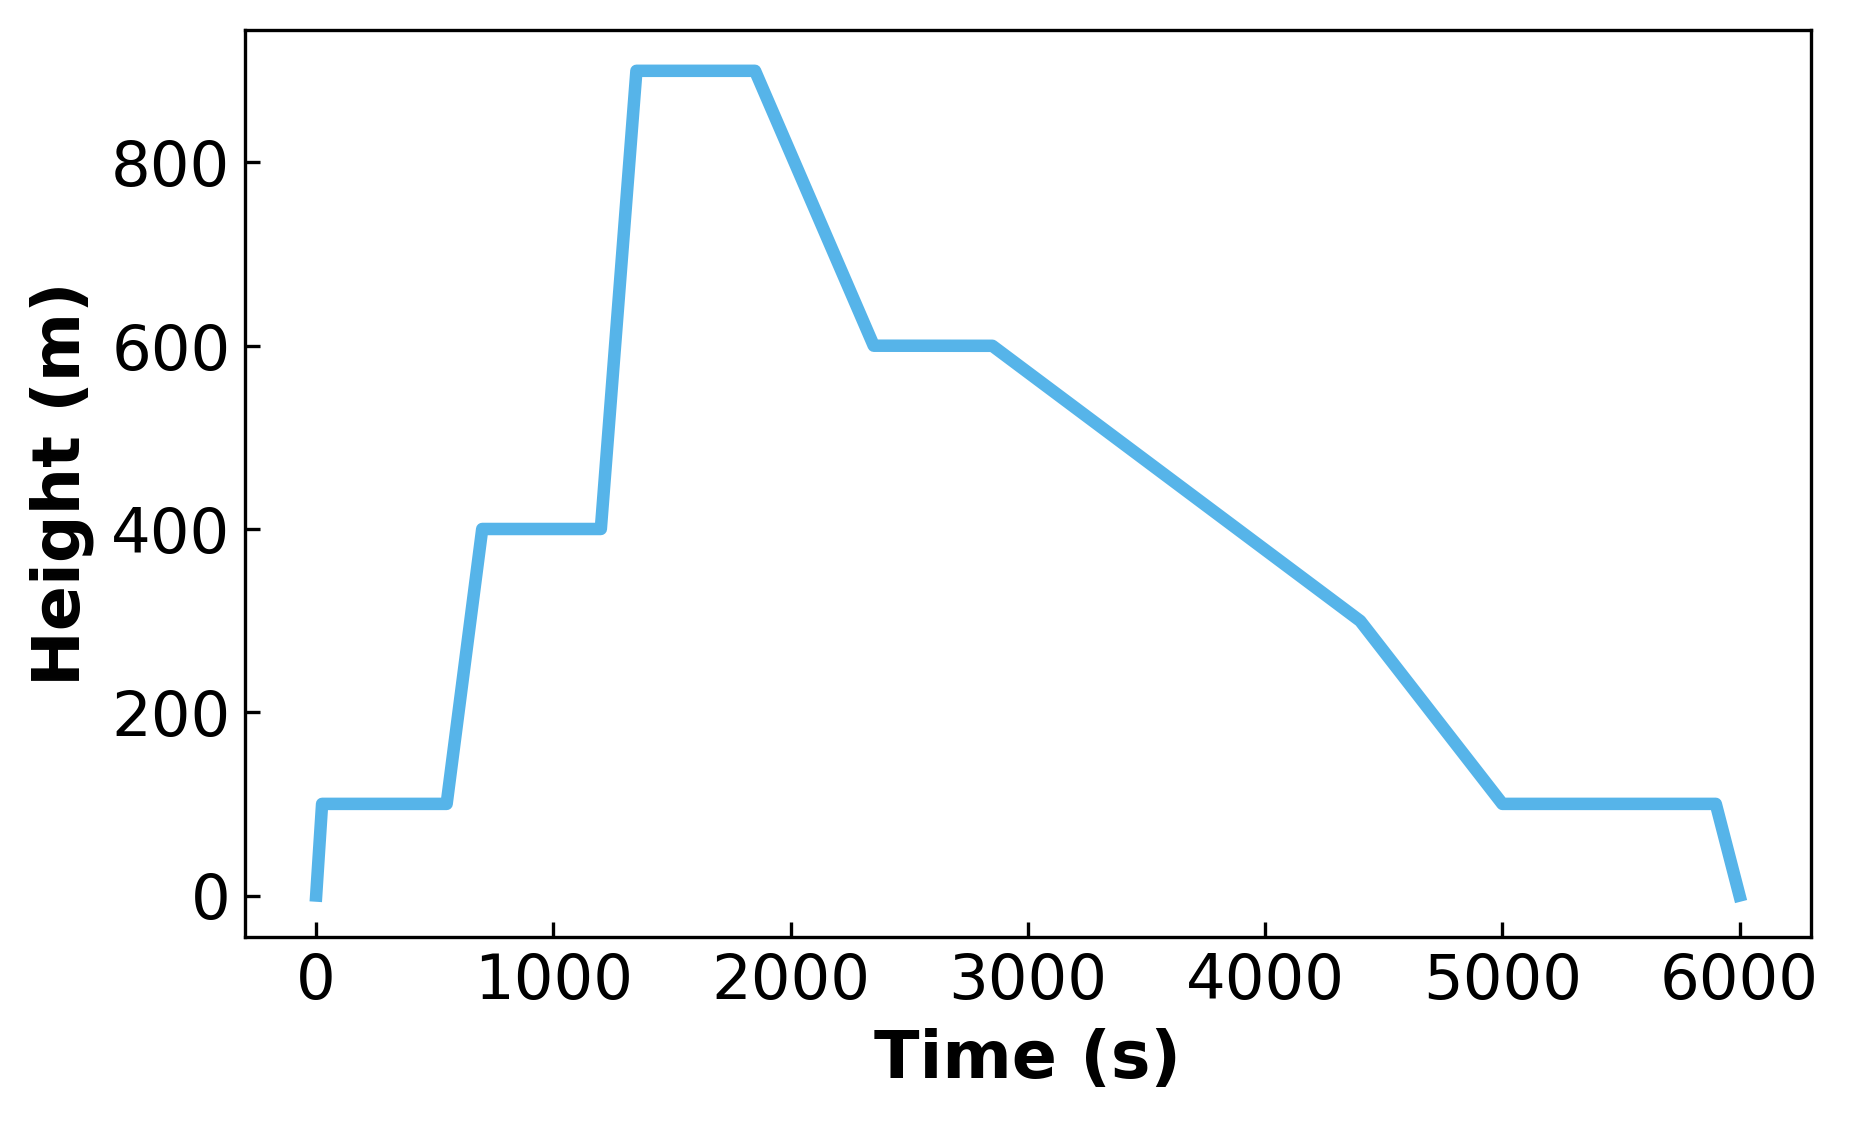

In [19]:
# time grid
tf = 6000 #sec in 100 minuts minutes
dt = 0.5
n = round(tf / dt)
t_grid = np.linspace(0, tf, n + 1)


# setpoint/reference
def r(t):
    return np.interp(t, [0, 25, 550, 700, 1200, 1350, 1850, 2350, 2850, 4400, 5000, 5900, tf], [0, 100, 100, 400, 400, 900, 900, 600, 600, 300, 100, 100, 0])



# plot the setpoint function
fig = plt.figure(dpi = 300, figsize= (6.4, 4))
plt.plot(t_grid, r(t_grid), label="setpoint", color = okabeito_list[0], linewidth = 3)
plt.xlabel('Time (s)', fontweight = 'bold', fontsize = 16)
plt.ylabel('Height (m)', fontweight = 'bold', fontsize = 16)
plt.tight_layout()
plt.tick_params(direction = 'in', labelsize=15)
plt.show()

`r(t)` is then used as the reference path in the previously set model.

In [20]:
def create_balloon_model_v4():


    # Define a Samll Constant to Help Stabalize the Drag Force Differential Equation
    eps = 1e-6

    # Create a Pyomo Model
    m = pyo.ConcreteModel('Hot Air Balloon')

    # Define Time Domain
    m.t = dae.ContinuousSet(bounds=(0, tf))

    # Define State Variables as Function of Time
    m.h = pyo.Var(m.t, bounds=(0, None))
    m.v = pyo.Var(m.t)
    m.D = pyo.Var(m.t)

    # Define Control Variable (Lift) as a Function of Time
    m.L = pyo.Var(m.t, bounds = (L_lb, L_ub))

    # Define Derivative Variables
    m.dhdt = dae.DerivativeVar(m.h, wrt=m.t)
    m.dvdt = dae.DerivativeVar(m.v, wrt=m.t)

    # Define Derivative Constraints
    # Height derivative constraint (dh/dt = v)
    def dh_con(m, t):
        return m.dhdt[t] == m.v[t]
    m.dh_con = pyo.Constraint(m.t, rule=dh_con)

    # Velocity derivative, acceleration constraint (m * dv/dt = L - mg - D)
    def dv_con(m, t):
        return m.dvdt[t] * m_balloon == m.L[t] - m_balloon * g - m.D[t]
    m.dv_con = pyo.Constraint(m.t, rule=dv_con)

    # Define Algebraic Contraints
    # Drag force calculation (D = b * v^2)
    def drag_con(m, t):
        return m.D[t] == b * (m.v[t]**2 + eps**2)**(1/2) * m.v[t]
    m.drag_con = pyo.Constraint(m.t, rule=drag_con)

    # Define the objective: Minimize the difference between final height and the desired height
    @m.Integral(m.t)
    def ise(m, t):
        return (m.h[t] - r(t))**2  # Minimize squared difference at final time


    # Define the objective function
    @m.Objective(sense=pyo.minimize)
    def objective(m):
        return m.ise

    # Set Initial conditions
    m.L[0].fix(10000)

    return m


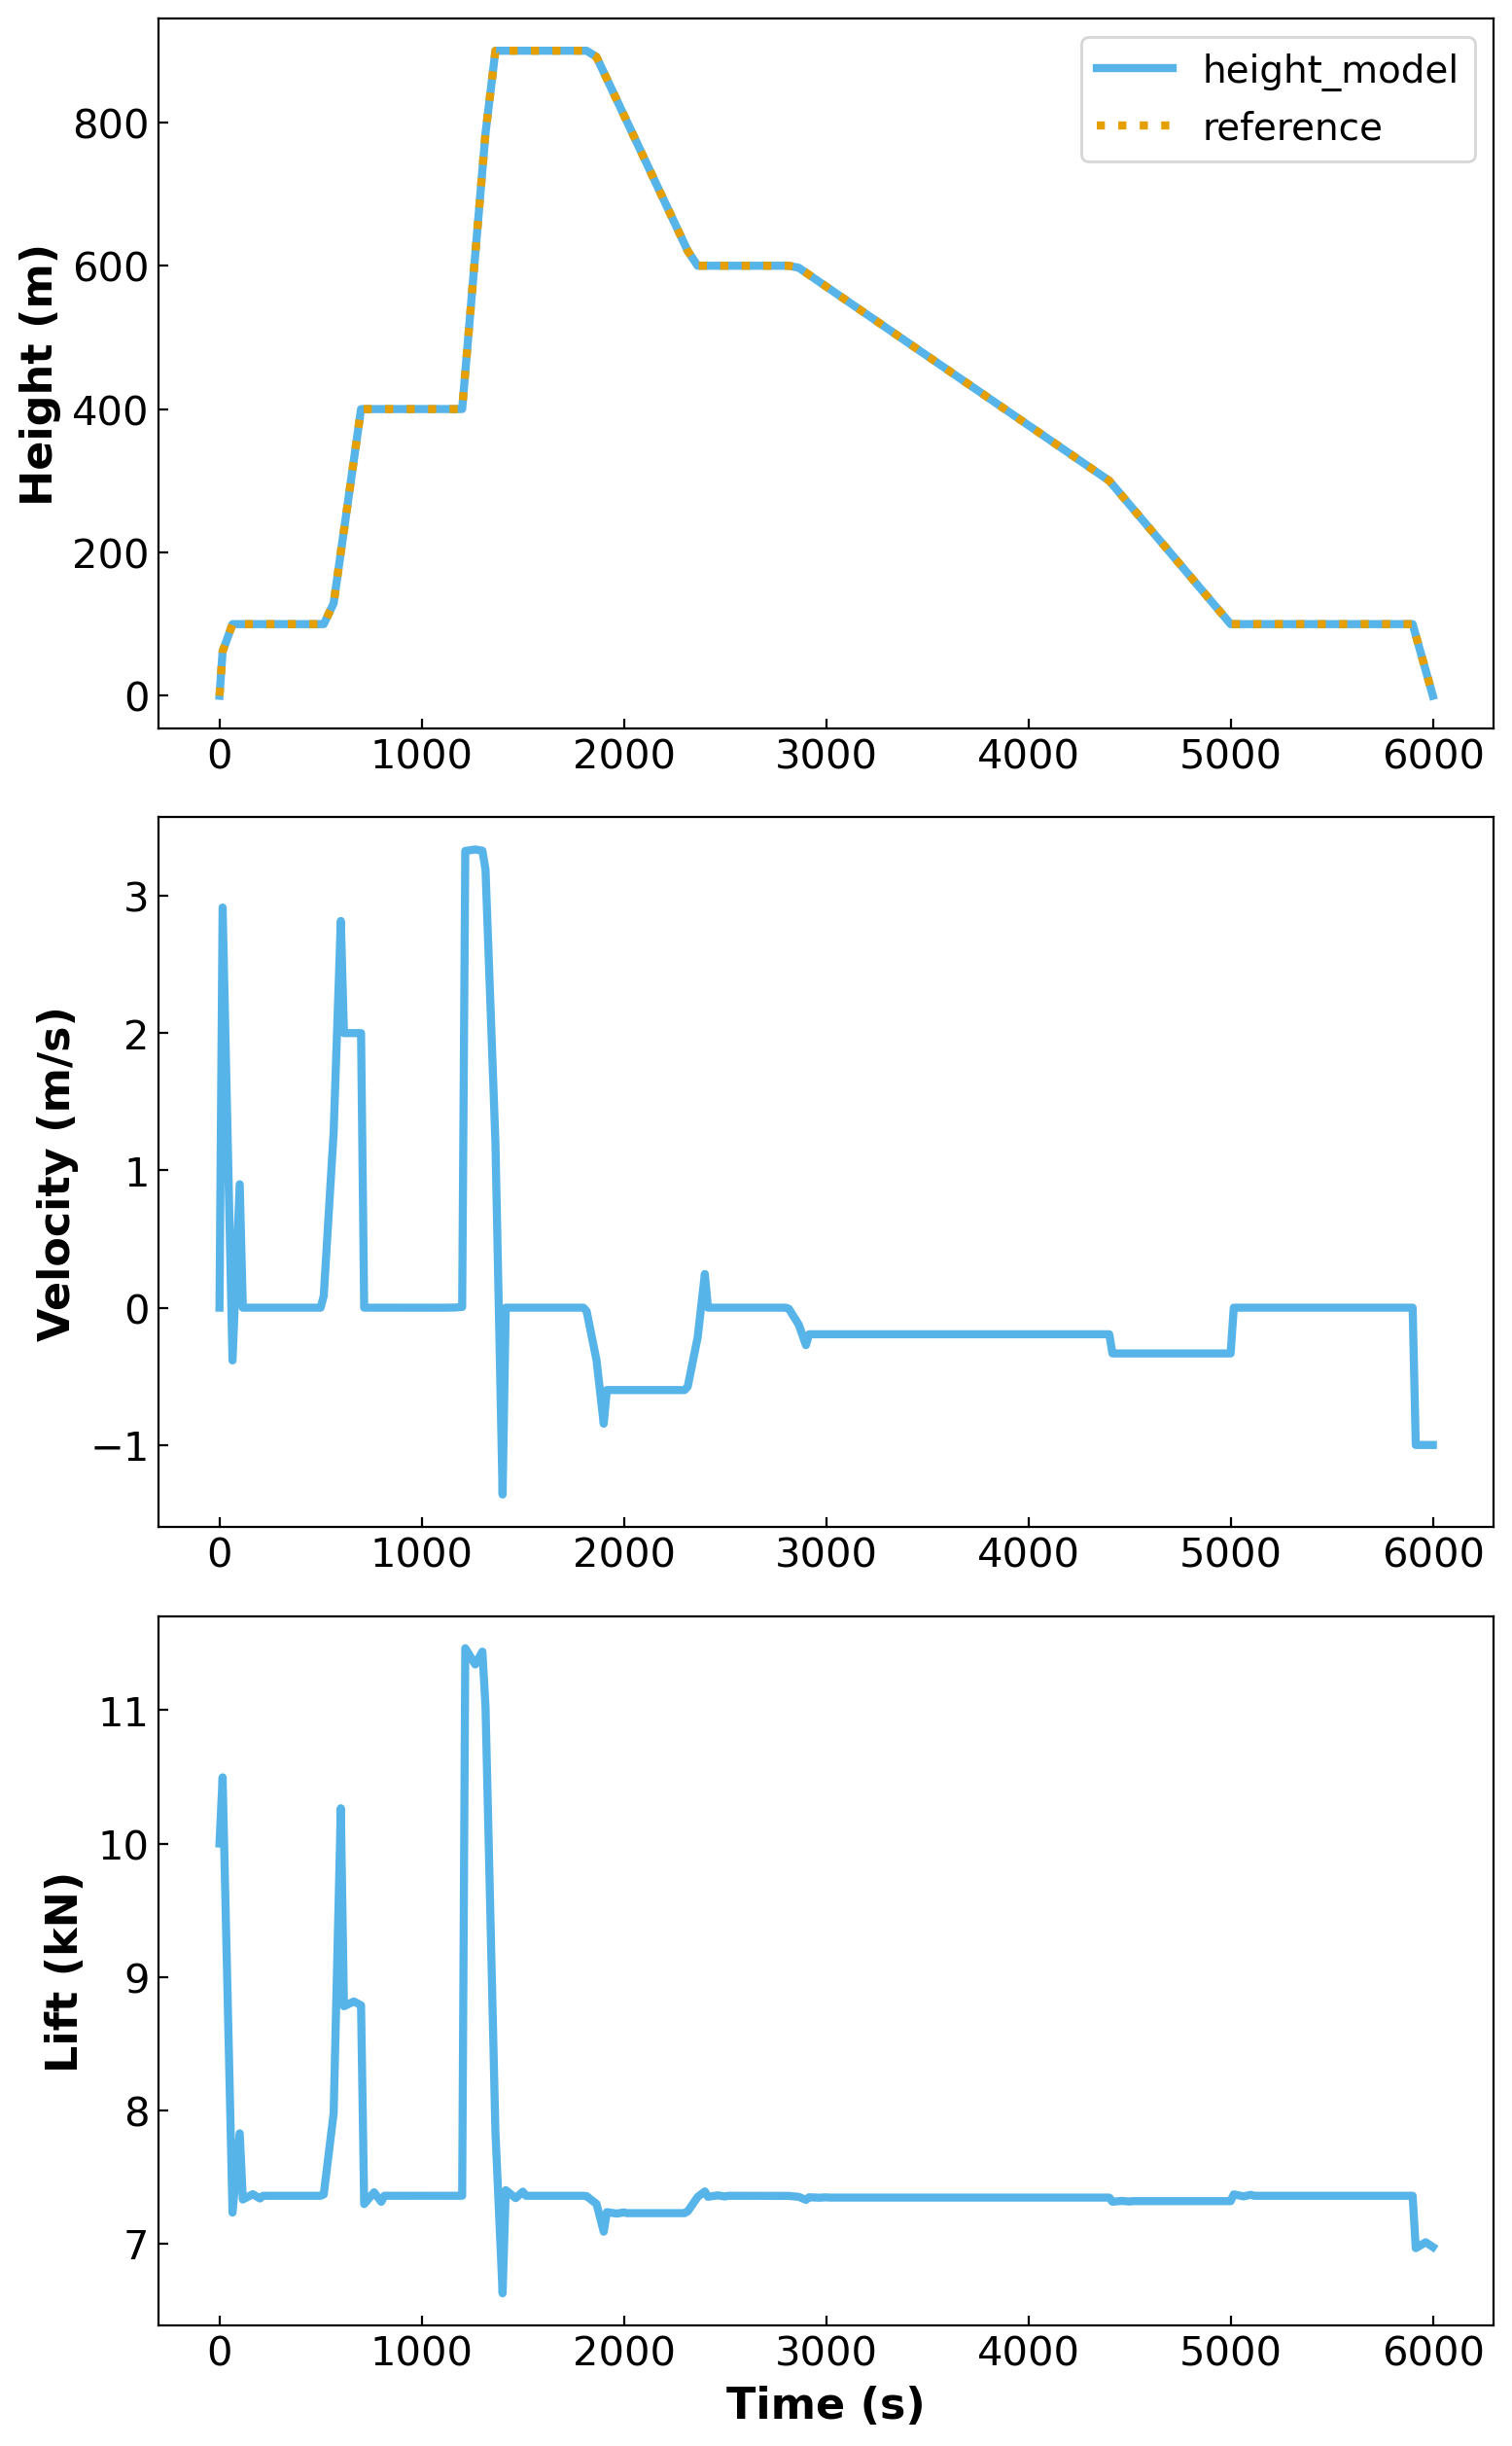

In [21]:
# Create model instance
tf = 6000
NFE = 60

model = create_balloon_model_v4()

# Call the Discretization/Initialization Function
discretize_initialize(model, NFE)

# Call the Solve Function
model = solve_model(model, tee = False)

# # Display the results
# for t in model.t:
#     if t % 300 == 0:
#         print(f"Time {t}: Height = {pyo.value(model.h[t])}, Velocity = {pyo.value(model.v[t])}, Lift = {pyo.value(model.L[t])}")

# Visualize solution
fig, axs = visualize_model(model)
# Add in plot for set height
h_set = [r(i) for i in model.t]
axs[0].plot(model.t, h_set, label="reference", linestyle = ':', linewidth = 3, color = okabeito_list[2])
axs[0].legend()
plt.tick_params(direction = 'in', labelsize=15)
plt.xlabel('Time (s)', fontweight = 'bold', fontsize = 16)
plt.ylabel('Lift (kN)', fontweight = 'bold', fontsize = 16)
plt.show()


While solution peaks look very sharp, keep in mind this is over a period of 6000s to simulate a full hot air balloon ride, which are usually around 90 minutes in length. Zooming in to the first quarter of the plot (0 - 1500s).

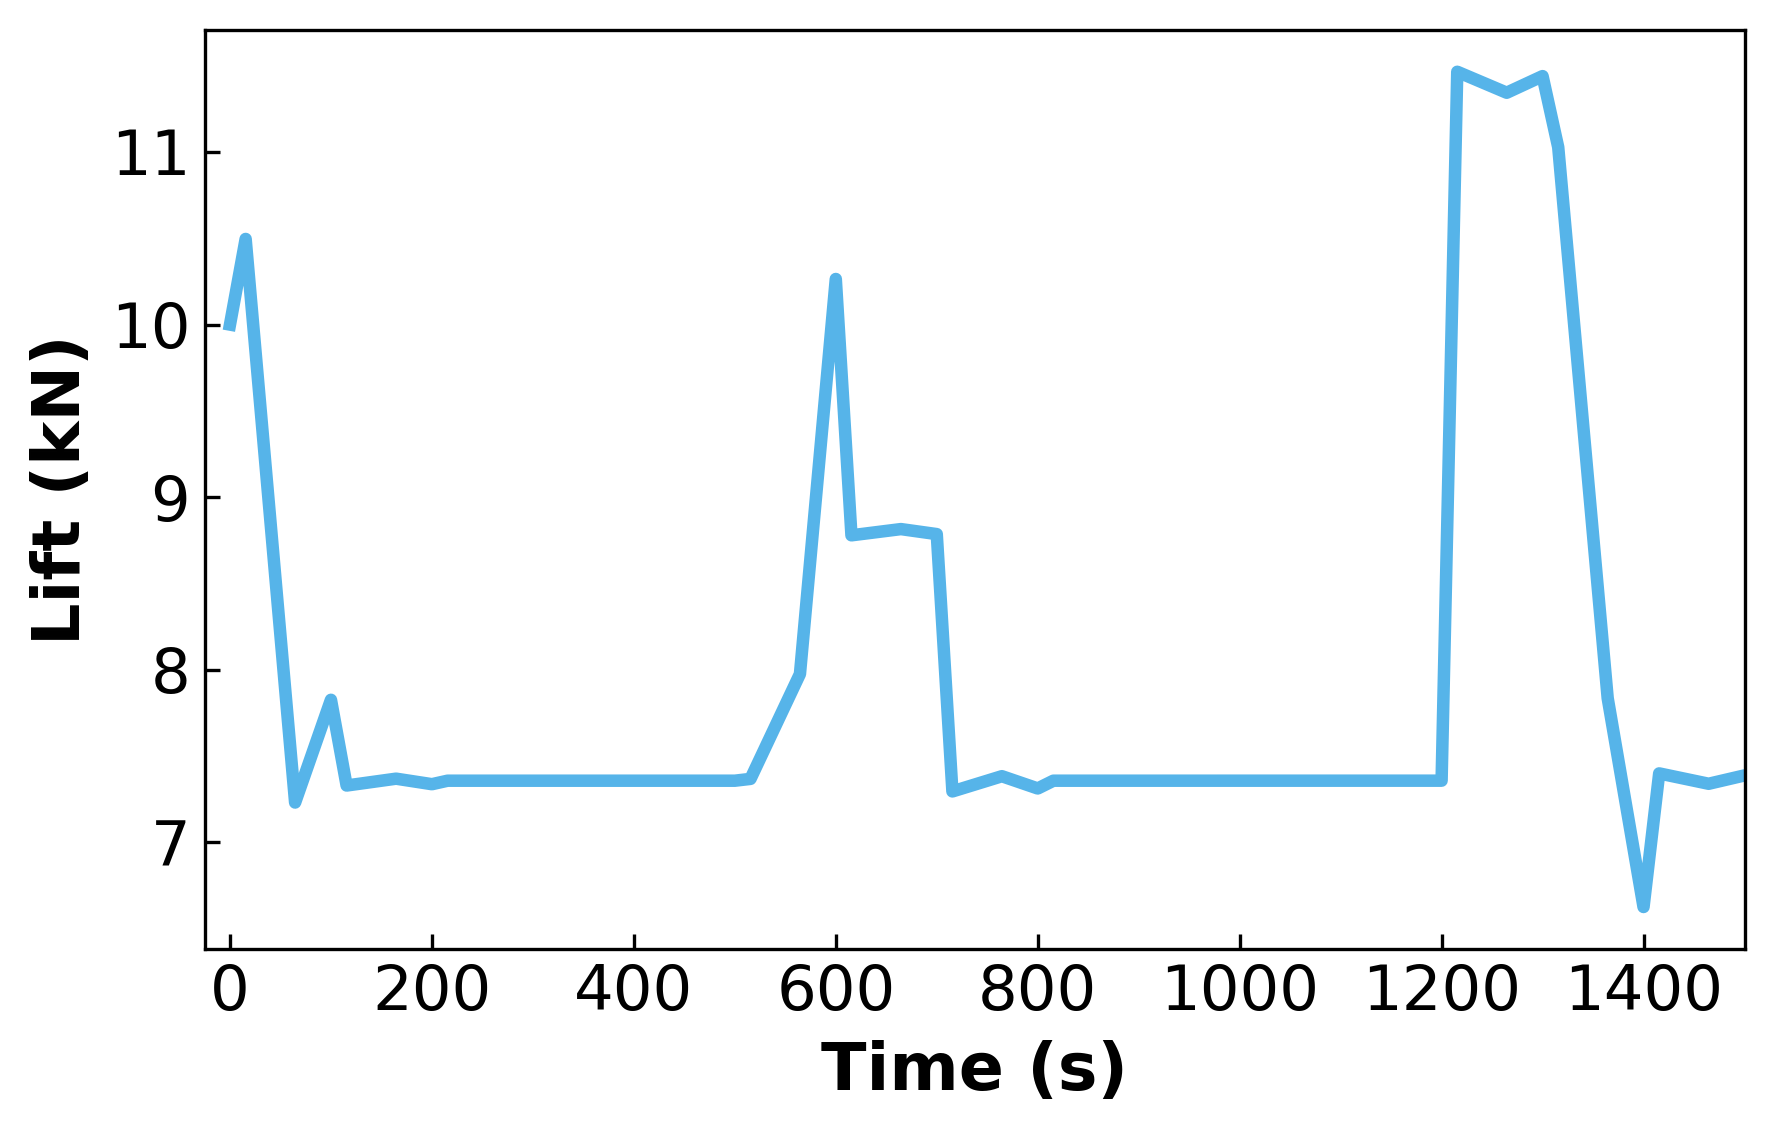

In [22]:
# Let us zoom in on key areas of the plot

t = [i for i in model.t]
L = [pyo.value(model.L[i])/1000 for i in model.t] #lift in kN

figure = plt.figure(dpi = 300, figsize = (6.4, 4))
plt.plot(t, L, linewidth = 3, color = colors[0])
plt.xlim(-25, 1500)
plt.tick_params(direction = 'in', labelsize=15)
plt.xlabel('Time (s)', fontweight = 'bold', fontsize = 16)
plt.ylabel('Lift (kN)', fontweight = 'bold', fontsize = 16)

plt.tight_layout()

plt.show()

## Conclusions

### Take Away Messages

1. It is important to check that initial values and conditions make sense for the physical system.

2. Understanding the model on paper saves a ton of time coding into pyomo.

3. Examples like TCLab have a large potential to be modified for a variety of applications including a hot air balloon.


### Future Work
  Potential next steps for this model include:

1.   Making a fuel estimation calculator. The lift would need to be related to the propane flowrate from the burner, and this would allow for a cost minimization tool in trip planning for hot air balloons.
2.   Having the hot air balloon drag and lift calculations depend on height and temperature. This would add further complexity to the model and make the resulting curves more realistic.
3.   Adding in horizontal movement from wind would allow for a multidimensional hot air balloon model.
4.   Taking a specific design for a hot air balloon, a digital twin could be made to match the specifications and conduct uncertainty quantification against historic data.



## Extensions of Referenced Material



1.   Instead of defining a PID Controller, we implemented the equations of motion for a hot-air balloon in Pyomo and used an objective function to control the decision variable, lift.
2.   The Charm Lab at Stanford only investigated the ascent of a ballon as it traveled to a set height. They did not account for the balloon moving downward; thus, their formulation could not be extended to path planning. We extended their formulation by modifying the Drag equation and defining a flight path for a balloon to reach a set of heights during the balloon’s ascent and descent.



## References

1. (Hot Air Balloon Model) Bombik, A., & Mukhopadhaya, J. (2016). Controlling Team Rocket's Hot Air Balloon. Stanford University. https://charm.stanford.edu/ENGR1052016/AnthonyBombikJayantMukhopadhaya

2. (Pyomo.DAE Example) Temperature Control Lab: Dowling, A., et al. (2023). Optimal control with Pyomo.DAE. Notre Dame CBE 30324/40324: Process Optimization. Retrieved October 7, 2024, from https://ndcbe.github.io/optimization/notebooks/3/PyomoDAE_TCLab.html

3. (Hot Air Balloon Physics: Real-World Physics Problems) (n.d.). Hot air balloon physics. Retrieved October 7, 2024, from https://www.real-world-physics-problems.com/hot-air-balloon-physics.html

4. (Engineering Toolbox: Calculating the Lift Force) The Engineering ToolBox. (n.d.). Hot air balloon lifting force. Retrieved October 7, 2024, from https://www.engineeringtoolbox.com/hot-air-balloon-lifting-force-d_562.html